##ANALISIS EXPLORATORIO Y MODELOS PREDICTIVOS - TFM - SERVICIOS PSICOSOCIALES  IDIPRON
###Jaime Guzmán Pantoja

#Configuaciones Iniciales

In [ ]:
# Importar Librerias generales
!pip install unidecode
import pandas as pd
import io
from google.colab import files
import numpy as np
import time
import matplotlib.pyplot as plt
import geopandas as gpd
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Instalación de dependencias necesarias
!pip install unidecode
!pip install geopandas

import pandas as pd
import sys

sys.path.append('/content/drive/My Drive/Base de Datos_TFM/PROYECTO_FINAL_TFM')

from excel_to_csv_converter import ExcelToCsvConverter

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from unidecode import unidecode

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [ ]:

from excel_to_csv_converter import ExcelToCsvConverter

# Ruta base donde se encuentran archivos xlsx
ruta_base = '/content/drive/My Drive/Base de Datos_TFM/PROYECTO_FINAL_TFM/'

# Base de datos: IDIPRON.xlsx
converter = ExcelToCsvConverter(ruta_base + 'IDIPRON.xlsx', 'idipron.csv', 'BASE', '|')
converter.convert_to_csv()


Conversion complete. Excel file /content/drive/My Drive/Base de Datos_TFM/PROYECTO_FINAL_TFM/IDIPRON.xlsx converted to CSV file idipron.csv with | as delimiter.


In [ ]:
idipron = pd.read_csv('idipron.csv', encoding='utf-8', sep='|')


<ipython-input-37-cc1953e38b71>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  idipron = pd.read_csv('idipron.csv', encoding='utf-8', sep='|')


In [ ]:
idipron.shape

(98848, 35)

In [ ]:
idipron['ANIO'] = idipron['FECHA_FICHA'].str.split('-').str[0].astype(int)
idipron = idipron[idipron['ANIO']  >= 2018]

idipron.shape

(44067, 36)

In [ ]:
## Data faltante en df de idipron
idipron.isnull().sum()
porcentaje_nulos = (idipron.isnull().mean() * 100).round(2)
porcentaje_nulos

ID_NNAJ_NU                  0.00
FECHA_FICHA                 0.00
FECHA_NACIMIENTO            0.00
EDAD ACTUAL                 0.00
EDAD FICHA                  0.00
PAIS                        0.00
DEPARTAMENTO_NACIMIENTO     0.00
MUNICIPIO_NACIMIENTO        0.00
SEXO                        0.00
TIPO_DOCUMENTO              0.00
DOCUMENTO                   0.00
ESTADO_CIVIL                0.00
ESTRATO                     0.00
LOCALIDAD                   0.00
UPZ                         1.42
BARRIO                      1.42
NIVEL_                      0.01
TIENE DISCAPACIDAD          0.00
TIPO_DISCAPACIDAD           0.00
NUMERO_HIJOS               80.18
TIPO_POBLACION_             0.00
CONTACTO                    0.00
VALORACIONES                0.00
INTERVENCIONES              0.00
CONSULTAS                   0.00
PLAN DE INTERVENCION        0.00
DAST                        0.00
VESPA                       0.00
CASO JURIDICO               0.00
DOCUMENTACION               0.00
ATENCION M

# Análisis Exploratorio


## Pirámide poblacional

In [ ]:
### Creación de grupo etario

def asignar_grupo_etario(edad):
    if edad <= 10:
        return '0-10'
    elif 11 <= edad <= 12:
        return '11-12'
    elif 13 <= edad <= 14:
        return '13-14'
    elif 15 <= edad <= 16:
        return '15-16'
    elif 17 <= edad <= 18:
        return '17-18'
    elif 19 <= edad <= 20:
        return '19-20'
    elif 21 <= edad <= 22:
        return '21-22'
    elif 23 <= edad <= 24:
        return '23-24'
    elif 25 <= edad <= 26:
        return '25-26'
    elif 27 <= edad <= 28:
        return '27-28'
    elif 29 <= edad <= 30:
        return '29-30'
    elif 31 <= edad <= 32:
        return '31-32'
    elif 33 <= edad <= 34:
        return '33-34'
    elif 35 <= edad <= 36:
        return '35-36'
    elif 37 <= edad <= 38:
        return '37-38'
    elif 39 <= edad <= 40:
        return '39-40'
    else:
        return 'Más de 40'


# Aplicar la función condicional a la columna 'Edad' de la base idipron
idipron['GRUPO_ETARIO'] = idipron['EDAD ACTUAL'].apply(asignar_grupo_etario)
idipron.shape



(44067, 37)

In [ ]:
# Crear nueva bd con conteo por edad y grupo etario
idipron_piramide_df = idipron.groupby(['SEXO', 'GRUPO_ETARIO']).size().reset_index(name='CUENTA')
idipron_piramide_df = idipron_piramide_df[idipron_piramide_df['SEXO'] != 'INTERSEXUAL'] # Se excluyen los intersexuales con el fin de poder realizar la piramide
idipron_piramide_df.head()

,SEXO,GRUPO_ETARIO,CUENTA
0,HOMBRE,0-10,819
1,HOMBRE,11-12,652
2,HOMBRE,13-14,739
3,HOMBRE,15-16,1057
4,HOMBRE,17-18,1816


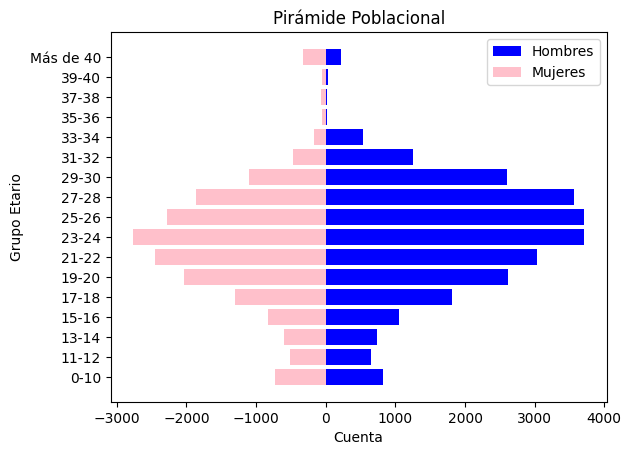

In [ ]:
# Crear un DataFrame pivote para tener 'Sexo' como columnas
pivot_df = idipron_piramide_df.pivot(index='GRUPO_ETARIO', columns='SEXO', values='CUENTA')

# Crear la pirámide poblacional
fig, ax = plt.subplots()

# Barras para Hombres
ax.barh(pivot_df.index, pivot_df['HOMBRE'], color='blue', label='Hombres')

# Barras para Mujeres con valores negativos para apilarlas en el lado izquierdo
ax.barh(pivot_df.index, -pivot_df['MUJER'], color='pink', label='Mujeres')

# Configuración del gráfico
ax.set_xlabel('Cuenta')
ax.set_ylabel('Grupo Etario')
ax.set_title('Pirámide Poblacional')
ax.legend()

# Mostrar el gráfico
plt.show()

## Variables geográficas

### Lugar de nacimiento

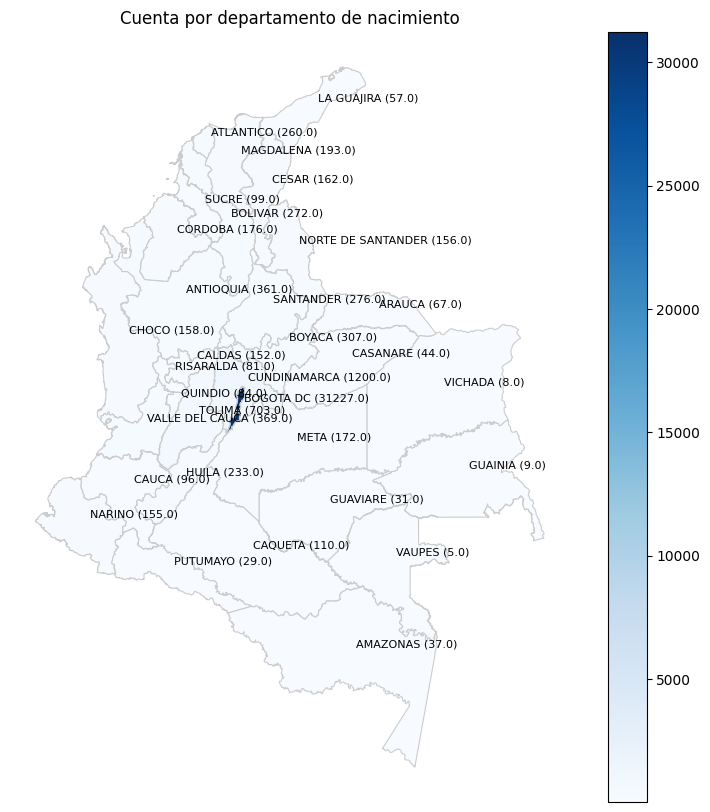

In [ ]:
# Cargar shape file de mapa de división administrativa
#colombia_div_admin = gpd.read_file('MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp')
colombia_div_admin = gpd.read_file('/content/drive/My Drive/Base de Datos_TFM/PROYECTO_FINAL_TFM/MGN2021_DPTO_POLITICO/MGN_DPTO_POLITICO.shp')
colombia_div_admin["DPTO_CNMBR"] = colombia_div_admin["DPTO_CNMBR"].apply(unidecode)
colombia_div_admin['DPTO_CNMBR'] = colombia_div_admin['DPTO_CNMBR'].replace(['\.', ','], '', regex=True)


# Crear df con departamento de nacimiento y conteo
idipron_ubicacion_df = idipron.groupby(['DEPARTAMENTO_NACIMIENTO']).size().reset_index(name='CUENTA')
idipron_ubicacion_df["DEPARTAMENTO_NACIMIENTO"] = idipron_ubicacion_df["DEPARTAMENTO_NACIMIENTO"].apply(unidecode)
idipron_ubicacion_df['DEPARTAMENTO_NACIMIENTO'] = idipron_ubicacion_df['DEPARTAMENTO_NACIMIENTO'].replace(['\.', ','], '', regex=True)

#idipron_ubicacion_df.head(100).sort_values(by='CUENTA', ascending=False)

df_conteo_div_admin = colombia_div_admin.merge(idipron_ubicacion_df, how='left', left_on='DPTO_CNMBR', right_on='DEPARTAMENTO_NACIMIENTO')

# Graficar mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_conteo_div_admin.plot(column='CUENTA', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Añadir etiquetas para todas las áreas
for idx, row in df_conteo_div_admin.iterrows():
    ax.annotate(
        f"{row['DPTO_CNMBR']} ({row['CUENTA']})",
        xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        color='black'
    )


ax.set_title('Cuenta por departamento de nacimiento')
ax.set_axis_off()
plt.show()


### UPZ de afiliación

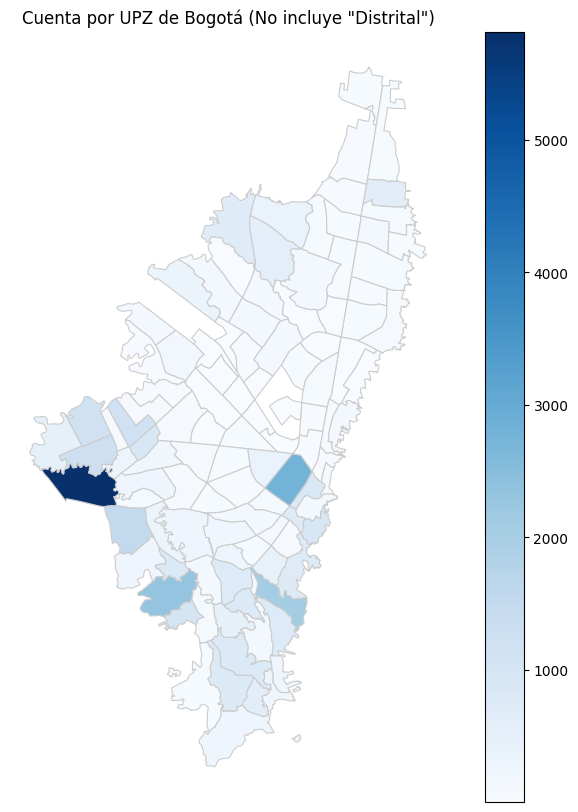

In [ ]:
# Cargar shape file de mapa UPZ Bogota
upz_bogota = gpd.read_file('/content/drive/My Drive/Base de Datos_TFM/PROYECTO_FINAL_TFM/UPZ_BOGOTA/upz-bogota.shp')

#limpiar columna 'nombre'
upz_bogota["nombre"] = upz_bogota["nombre"].apply(unidecode).replace(['\.', ','], '', regex=True)

# agrupar por UPZ
idipron_upz_df = idipron.groupby(['UPZ']).size().reset_index(name='CUENTA').sort_values(by="UPZ")

#limpiar columna 'UPZ'
idipron_upz_df["UPZ"] = idipron_upz_df["UPZ"].apply(unidecode).replace(['\.', ','], '', regex=True)

# se vuelve agrupar despues de limpiar
idipron_upz_df = idipron_upz_df.groupby(['UPZ']).sum().reset_index()

# Unión de df con conteo y geometria
df_conteo_upz_bogota = upz_bogota.merge(idipron_upz_df, how='left', left_on='nombre', right_on='UPZ')

# Graficar mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_conteo_upz_bogota.plot(column='CUENTA', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Cuenta por UPZ de Bogotá (No incluye "Distrital")')
ax.set_axis_off()

### Localidad de afiliación

In [ ]:
idipron_localidad_bogota = idipron.groupby(['LOCALIDAD']).size().reset_index(name='CUENTA').sort_values(by="CUENTA")
idipron_localidad_bogota.head(20)

,LOCALIDAD,CUENTA
19,21 SUMAPAZ,36
12,13 TEUSAQUILLO,75
20,78 SOACHA,86
16,17 LA CANDELARIA,125
11,12 BARRIOS UNIDOS,190
14,15 ANTONIO NARIÑO,264
8,09 FONTIBÓN,343
1,02 CHAPINERO,375
5,06 TUNJUELITO,416
15,16 PUENTE ARANDA,582


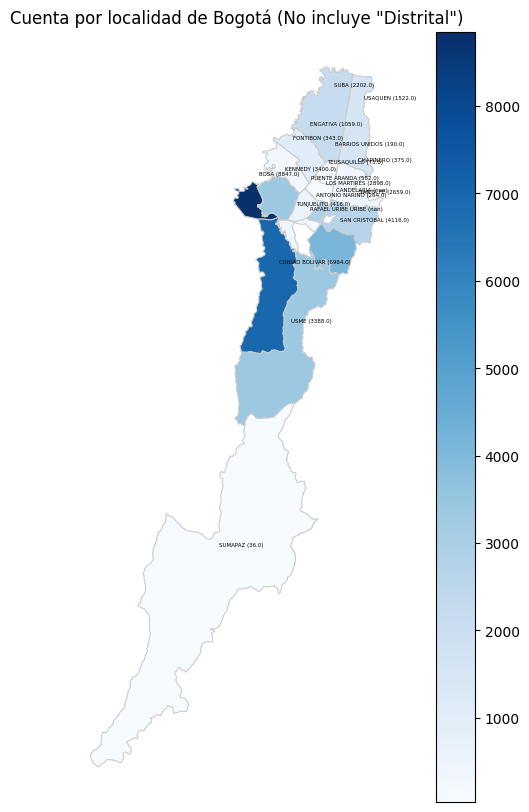

In [ ]:
# Cargar shape file de mapa localidades Bogota
localidad_bogota = gpd.read_file('/content/drive/My Drive/Base de Datos_TFM/PROYECTO_FINAL_TFM/LOCALIDADES_BOGOTA/Loca.shp')
localidad_bogota["LocNombre"] = localidad_bogota["LocNombre"].apply(unidecode).replace(['\.', ','], '', regex=True)

# agrupar por UPZ
idipron_localidad_bogota = idipron.groupby(['LOCALIDAD']).size().reset_index(name='CUENTA').sort_values(by="LOCALIDAD")
idipron_localidad_bogota["LOCALIDAD"] = idipron_localidad_bogota["LOCALIDAD"].apply(unidecode).replace(['\.', ','], '', regex=True).str[3:]

# se vuelve agrupar despues de limpiar
idipron_localidad_bogota = idipron_localidad_bogota.groupby(['LOCALIDAD']).sum().reset_index()

# Unión de df con conteo y geometria
df_conteo_localidad_bogota = localidad_bogota.merge(idipron_localidad_bogota, how='left', left_on='LocNombre', right_on='LOCALIDAD')

# Graficar mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_conteo_localidad_bogota.plot(column='CUENTA', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Añadir etiquetas para todas las áreas
for idx, row in df_conteo_localidad_bogota.iterrows():
    ax.annotate(
        f"{row['LocNombre']} ({row['CUENTA']})",
        xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
        xytext=(5, 20),
        textcoords='offset points',
        fontsize=4,
        color='black'
    )

ax.set_title('Cuenta por localidad de Bogotá (No incluye "Distrital")')
ax.set_axis_off()

## Variables demográficas

### Estado civil

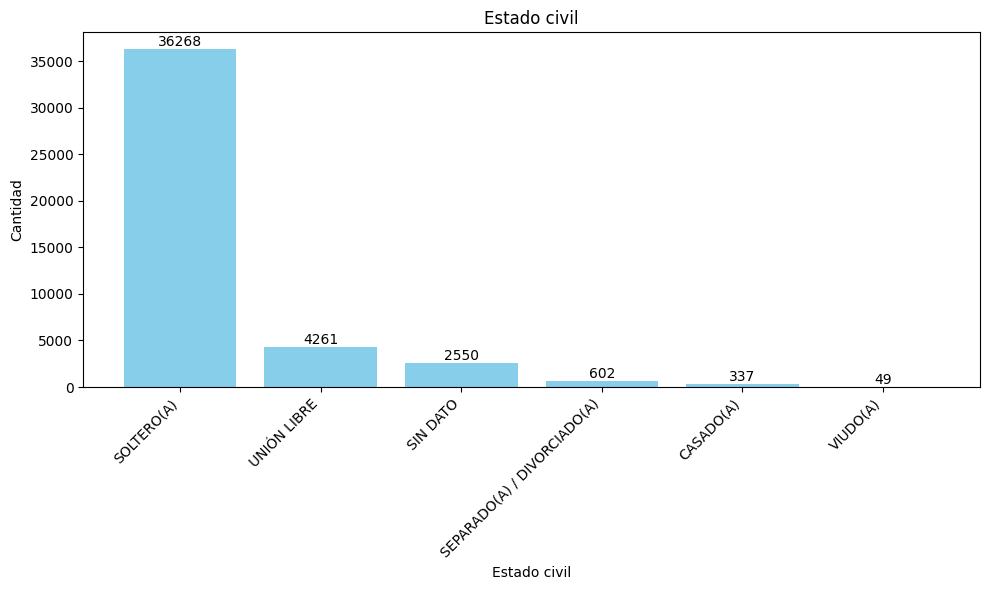

In [ ]:
idipron_estado_civil_df = idipron.groupby(['ESTADO_CIVIL']).size().reset_index(name='CUENTA').sort_values(by="CUENTA", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(idipron_estado_civil_df['ESTADO_CIVIL'], idipron_estado_civil_df['CUENTA'], color='skyblue')

# Se crea la figura
plt.xlabel('Estado civil')
plt.ylabel('Cantidad')
plt.title('Estado civil')

plt.xticks(rotation=45, ha='right')

for i, value in enumerate(idipron_estado_civil_df['CUENTA']):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')

# Mostrar gráfica
plt.tight_layout()
plt.show()

### Discapacidad

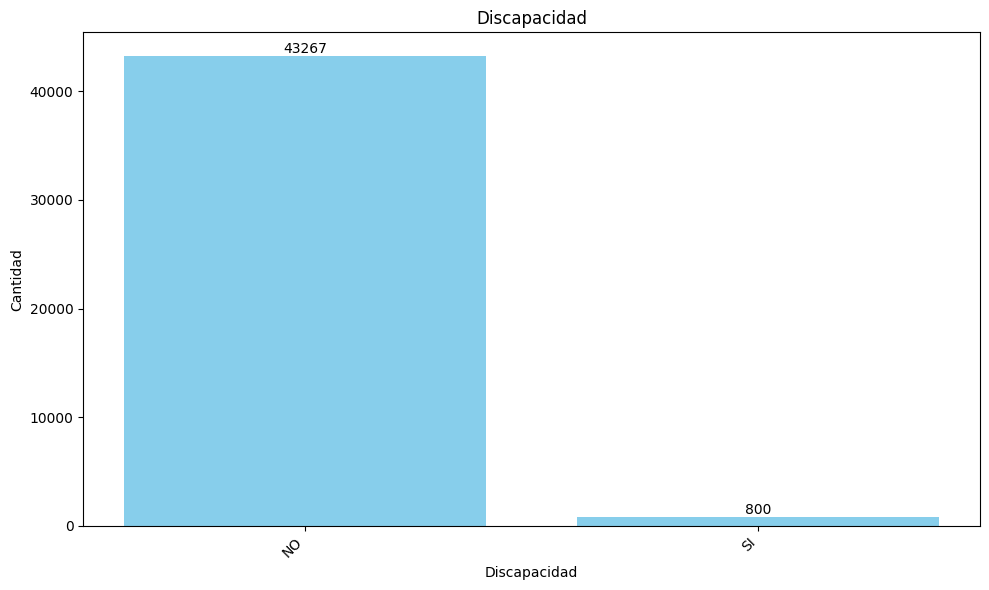

In [ ]:
idipron_disc_civil_df = idipron.groupby(['TIENE DISCAPACIDAD']).size().reset_index(name='CUENTA').sort_values(by="CUENTA", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(idipron_disc_civil_df['TIENE DISCAPACIDAD'], idipron_disc_civil_df['CUENTA'], color='skyblue')

# Se crea la figura
plt.xlabel('Discapacidad')
plt.ylabel('Cantidad')
plt.title('Discapacidad')

plt.xticks(rotation=45, ha='right')

for i, value in enumerate(idipron_disc_civil_df['CUENTA']):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')

# Mostrar gráfica
plt.tight_layout()
plt.show()

### Estrato

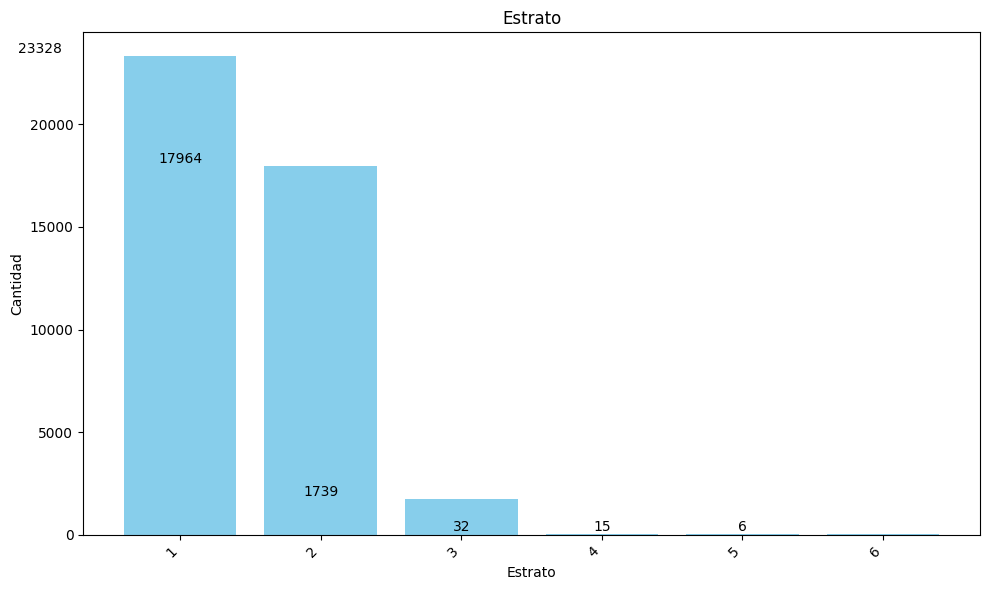

In [ ]:
# Llenando con los estratos que tiene "SIN DATO" con la moda del estrato por barrio

idipron['ESTRATO'] = idipron['ESTRATO'].apply(lambda x: None if x == 'SIN DATO' else x)

def fill_missing_mode(group):
    mode_values = group['ESTRATO'].mode()
    if not mode_values.empty:
        mode_value = mode_values.iloc[0]
        group['ESTRATO'] = group['ESTRATO'].fillna(mode_value)
    return group

# Aplicando la funcion
idipron['ESTRATO'] = idipron['ESTRATO'].astype('Int64')
idipron = idipron.groupby('BARRIO').apply(fill_missing_mode)

# Eliminando lo que es nulo, un pequeño porcentaje
idipron = idipron[idipron['ESTRATO']>=0]

idipron_estrato_civil_df = idipron.groupby(['ESTRATO']).size().reset_index(name='CUENTA').sort_values(by="CUENTA", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(idipron_estrato_civil_df['ESTRATO'], idipron_estrato_civil_df['CUENTA'], color='skyblue')

# Creando figura
plt.xlabel('Estrato')
plt.ylabel('Cantidad')
plt.title('Estrato')

plt.xticks(rotation=45, ha='right')

for i, value in enumerate(idipron_estrato_civil_df['CUENTA']):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')

# Mostrar gráfica
plt.tight_layout()
plt.show()

### Escolaridad

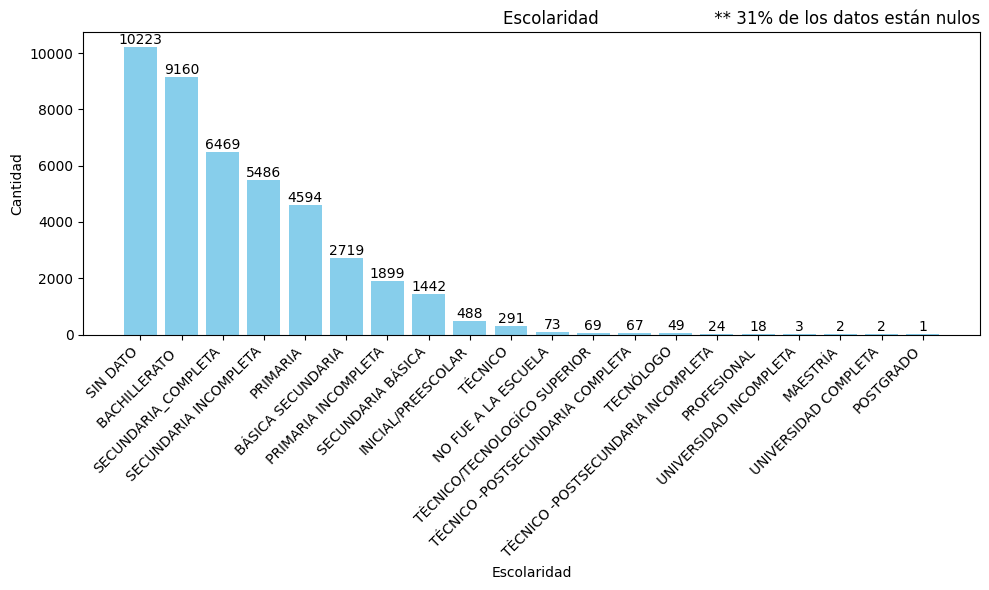

In [ ]:
idipron_escolaridad_df = idipron.groupby(['NIVEL_']).size().reset_index(name='CUENTA').sort_values(by="CUENTA", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(idipron_escolaridad_df['NIVEL_'], idipron_escolaridad_df['CUENTA'], color='skyblue')

# Creando gráfica
plt.xlabel('Escolaridad')
plt.ylabel('Cantidad')
plt.title('Escolaridad                      ** 31% de los datos están nulos', loc='right')

plt.xticks(rotation=45, ha='right')

for i, value in enumerate(idipron_escolaridad_df['CUENTA']):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')

# Mostrar gráfica
plt.tight_layout()
plt.show()


### Número de hijos

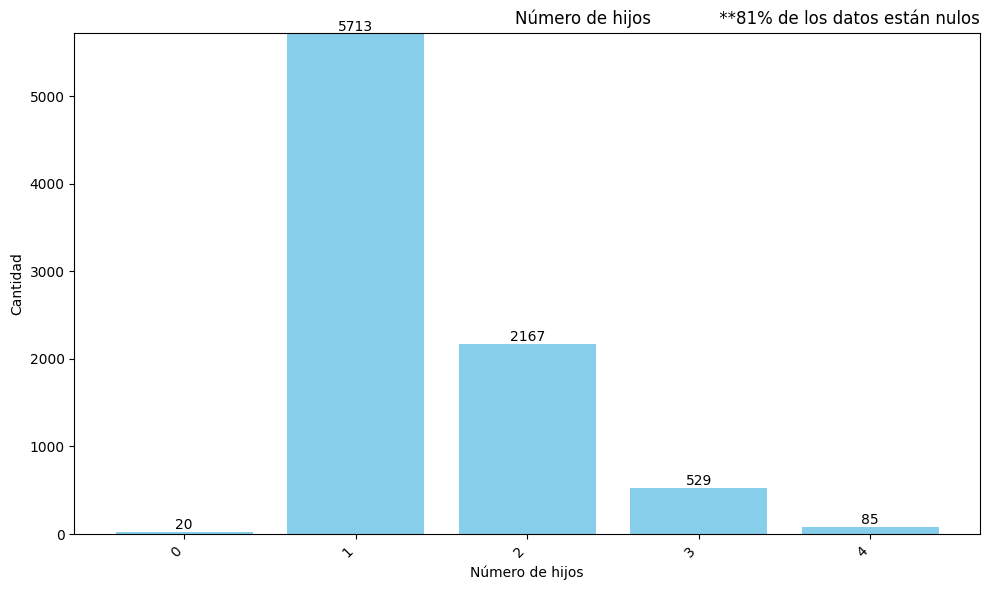

In [ ]:
idipron_n_hijos_df = idipron.groupby(['NUMERO_HIJOS']).size().reset_index(name='CUENTA').sort_values(by="CUENTA", ascending=False)

plt.figure(figsize=(10, 6))

bars = plt.bar(idipron_n_hijos_df['NUMERO_HIJOS'], idipron_n_hijos_df['CUENTA'], color='skyblue', align='center')
plt.ylim(0, idipron_n_hijos_df['CUENTA'].max() + 10)

# Creando gráfica
plt.xlabel('Número de hijos')
plt.ylabel('Cantidad')
plt.title('Número de hijos             **81% de los datos están nulos', loc='right')

plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, str(int(yval)), ha='center', va='bottom')

# Mostrar grafica
plt.tight_layout()
plt.show()

# Análisis predictivo

In [ ]:
#Se llevan a cabo las diferentes transformaciones de los valores categoricos.
idipron['VALORACIONES_B'] = idipron['VALORACIONES'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['INTERVENCIONES_B'] = idipron['INTERVENCIONES'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['CONSULTAS_B'] = idipron['CONSULTAS'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['PLAN_DE_INTERVENCION_B'] = idipron['PLAN DE INTERVENCION'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['DAST_B'] = idipron['DAST'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['VESPA_B'] = idipron['VESPA'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['CASO_JURIDICO_B'] = idipron['CASO JURIDICO'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['DOCUMENTACION_B'] = idipron['DOCUMENTACION'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['ATENCION_MEDICA_B'] = idipron['ATENCION MEDICA'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['ATENCION_ENFERMERIA_B'] = idipron['ATENCION ENFERMERIA'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['ODONTOLOGIA_B'] = idipron['ODONTOLOGIA'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['NUTRICION_B'] = idipron['NUTRICION'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['TERAPIA_OCUPACIONAL_B'] = idipron['TERAPIA OCUPACIONAL'].apply(lambda x: 1 if x == 'SI' else 0)
idipron['SEXO_B'] = idipron['SEXO'].apply(lambda x: 1 if x == 'HOMBRE' else 0)
idipron['TIENE_DISCAPACIDAD_B'] = idipron['TIENE DISCAPACIDAD'].apply(lambda x: 1 if x == 'SI' else 0)

idipron.rename(columns={'EDAD ACTUAL': 'EDAD_ACTUAL'}, inplace=True)

# codificar la variable estado civil
label_encoder = LabelEncoder()

idipron['ESTADO_CIVIL_ENCODED'] = label_encoder.fit_transform(idipron['ESTADO_CIVIL'])

# Base final para prediccion
idipron_final = idipron[['EDAD_ACTUAL', 'SEXO_B', 'TIENE_DISCAPACIDAD_B','ESTADO_CIVIL_ENCODED','ESTRATO',
       'VALORACIONES_B', 'INTERVENCIONES_B',
       'CONSULTAS_B', 'PLAN_DE_INTERVENCION_B', 'DAST_B', 'VESPA_B',
       'CASO_JURIDICO_B', 'DOCUMENTACION_B', 'ATENCION_MEDICA_B',
       'ATENCION_ENFERMERIA_B', 'ODONTOLOGIA_B', 'NUTRICION_B',
       'TERAPIA_OCUPACIONAL_B']]

idipron_final.isnull().sum()
porcentaje_nulos = (idipron_final.isnull().mean() * 100).round(2)
porcentaje_nulos


EDAD_ACTUAL               0.0
SEXO_B                    0.0
TIENE_DISCAPACIDAD_B      0.0
ESTADO_CIVIL_ENCODED      0.0
ESTRATO                   0.0
VALORACIONES_B            0.0
INTERVENCIONES_B          0.0
CONSULTAS_B               0.0
PLAN_DE_INTERVENCION_B    0.0
DAST_B                    0.0
VESPA_B                   0.0
CASO_JURIDICO_B           0.0
DOCUMENTACION_B           0.0
ATENCION_MEDICA_B         0.0
ATENCION_ENFERMERIA_B     0.0
ODONTOLOGIA_B             0.0
NUTRICION_B               0.0
TERAPIA_OCUPACIONAL_B     0.0
dtype: float64

###Aplicación de Algoritmo Random Forest - elección variables mas relevantes en cada uno de los servicios a predecir

In [ ]:
#Algoritmo de RFC para obtener variables relevantes servicio VESPA

from sklearn.ensemble import RandomForestClassifier
import pandas as pd

selected_features_vespa = ['EDAD_ACTUAL', 'SEXO_B', 'TIENE_DISCAPACIDAD_B','ESTADO_CIVIL_ENCODED','ESTRATO',
       'VALORACIONES_B', 'INTERVENCIONES_B',
       'CONSULTAS_B', 'PLAN_DE_INTERVENCION_B', 'DAST_B',
       'CASO_JURIDICO_B', 'DOCUMENTACION_B', 'ATENCION_MEDICA_B',
       'ATENCION_ENFERMERIA_B', 'ODONTOLOGIA_B', 'NUTRICION_B',
       'TERAPIA_OCUPACIONAL_B']

# Inicialización del clasificador
classifier_rf = RandomForestClassifier(random_state=0)

# Entrenamiento del modelo
classifier_rf.fit(idipron_final.drop(['VESPA_B'], axis=1), idipron_final['VESPA_B'])

# Obtención de las importancias de las características como porcentajes
feature_importances_percentage = classifier_rf.feature_importances_ * 100

# Creación del DataFrame para las importancias de las características
feature_importances_df = pd.DataFrame({'Attributes': selected_features_vespa,
                                       'Importance': feature_importances_percentage})

# Ordenar el DataFrame por la columna 'Importance'
sorted_feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Impresión de las relevancias de las características ordenadas por importancia
print('Feature Relevances (Ordered by Importance)')
print(sorted_feature_importances_df)

Feature Relevances (Ordered by Importance)
                Attributes  Importance
0              EDAD_ACTUAL   27.113856
13   ATENCION_ENFERMERIA_B   18.236993
3     ESTADO_CIVIL_ENCODED   17.725597
6         INTERVENCIONES_B    7.661300
5           VALORACIONES_B    7.013399
4                  ESTRATO    3.588971
16   TERAPIA_OCUPACIONAL_B    3.046703
1                   SEXO_B    2.882311
10         CASO_JURIDICO_B    2.334773
12       ATENCION_MEDICA_B    2.058921
15             NUTRICION_B    1.964078
8   PLAN_DE_INTERVENCION_B    1.933305
7              CONSULTAS_B    1.757333
14           ODONTOLOGIA_B    1.293014
2     TIENE_DISCAPACIDAD_B    0.738968
11         DOCUMENTACION_B    0.474597
9                   DAST_B    0.175883


In [ ]:
print(27.11+18.23+17.72+7.66+7.01+3.58+3.58)

84.89


In [ ]:
#Algoritmo de RFC para obtener variables relevantes servicio ATENCION ENFERMERIA

from sklearn.ensemble import RandomForestClassifier
import pandas as pd

selected_features_vespa = ['EDAD_ACTUAL', 'SEXO_B', 'TIENE_DISCAPACIDAD_B','ESTADO_CIVIL_ENCODED','ESTRATO',
       'VALORACIONES_B', 'INTERVENCIONES_B',
       'CONSULTAS_B', 'PLAN_DE_INTERVENCION_B', 'DAST_B',
       'CASO_JURIDICO_B', 'DOCUMENTACION_B', 'ATENCION_MEDICA_B',
       'VESPA_B', 'ODONTOLOGIA_B', 'NUTRICION_B',
       'TERAPIA_OCUPACIONAL_B']


# Inicialización del clasificador
classifier_rf = RandomForestClassifier(random_state=0)

# Entrenamiento del modelo
classifier_rf.fit(idipron_final.drop(['ATENCION_ENFERMERIA_B'], axis=1), idipron_final['ATENCION_ENFERMERIA_B'])

# Obtención de las importancias de las características como porcentajes
feature_importances_percentage = classifier_rf.feature_importances_ * 100

# Creación del DataFrame para las importancias de las características
feature_importances_df = pd.DataFrame({'Attributes': selected_features_vespa,
                                       'Importance': feature_importances_percentage})

# Ordenar el DataFrame por la columna 'Importance'
sorted_feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Impresión de las relevancias de las características ordenadas por importancia
print('Feature Relevances (Ordered by Importance)')
print(sorted_feature_importances_df)

Feature Relevances (Ordered by Importance)
                Attributes  Importance
6         INTERVENCIONES_B   17.029031
0              EDAD_ACTUAL   12.651129
15             NUTRICION_B   11.576739
5           VALORACIONES_B   10.862375
16   TERAPIA_OCUPACIONAL_B   10.635131
13                 VESPA_B    8.056907
8   PLAN_DE_INTERVENCION_B    7.476924
14           ODONTOLOGIA_B    5.288384
10         CASO_JURIDICO_B    4.890519
4                  ESTRATO    2.334545
11         DOCUMENTACION_B    2.276015
3     ESTADO_CIVIL_ENCODED    1.904078
12       ATENCION_MEDICA_B    1.614091
1                   SEXO_B    1.440663
9                   DAST_B    0.874192
7              CONSULTAS_B    0.696574
2     TIENE_DISCAPACIDAD_B    0.392703


In [ ]:
print(17.02+12.65+11.57+10.86+10.63+8.05+7.47+5.28+4.89)

88.42


In [ ]:
#Algoritmo de RFC para obtener variables relevantes servicio INTERVENCIONES

from sklearn.ensemble import RandomForestClassifier
import pandas as pd

selected_features_vespa = ['EDAD_ACTUAL', 'SEXO_B', 'TIENE_DISCAPACIDAD_B','ESTADO_CIVIL_ENCODED','ESTRATO',
       'VALORACIONES_B', 'ATENCION_ENFERMERIA_B',
       'CONSULTAS_B', 'PLAN_DE_INTERVENCION_B', 'DAST_B',
       'CASO_JURIDICO_B', 'DOCUMENTACION_B', 'ATENCION_MEDICA_B',
       'VESPA_B', 'ODONTOLOGIA_B', 'NUTRICION_B',
       'TERAPIA_OCUPACIONAL_B']


# Inicialización del clasificador
classifier_rf = RandomForestClassifier(random_state=0)

# Entrenamiento del modelo
classifier_rf.fit(idipron_final.drop(['INTERVENCIONES_B'], axis=1), idipron_final['INTERVENCIONES_B'])

# Obtención de las importancias de las características como porcentajes
feature_importances_percentage = classifier_rf.feature_importances_ * 100

# Creación del DataFrame para las importancias de las características
feature_importances_df = pd.DataFrame({'Attributes': selected_features_vespa,
                                       'Importance': feature_importances_percentage})

# Ordenar el DataFrame por la columna 'Importance'
sorted_feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Impresión de las relevancias de las características ordenadas por importancia
print('Feature Relevances (Ordered by Importance)')
print(sorted_feature_importances_df)

Feature Relevances (Ordered by Importance)
                Attributes  Importance
5           VALORACIONES_B   19.590812
7              CONSULTAS_B   16.735904
0              EDAD_ACTUAL   14.270147
13                 VESPA_B   10.167573
12       ATENCION_MEDICA_B    8.504925
15             NUTRICION_B    6.671473
16   TERAPIA_OCUPACIONAL_B    6.023827
14           ODONTOLOGIA_B    3.547064
4                  ESTRATO    2.849567
10         CASO_JURIDICO_B    2.521419
3     ESTADO_CIVIL_ENCODED    2.094636
11         DOCUMENTACION_B    1.677673
1                   SEXO_B    1.629230
6    ATENCION_ENFERMERIA_B    1.184757
8   PLAN_DE_INTERVENCION_B    1.086222
9                   DAST_B    0.938541
2     TIENE_DISCAPACIDAD_B    0.506229


In [ ]:
print(19.59+16.73+14.27+10.16+8.50+6.67+6.02+3.54)

85.48


In [ ]:
#Algoritmo de RFC para obtener variables relevantes servicio 'NUTRICION'

from sklearn.ensemble import RandomForestClassifier
import pandas as pd

selected_features_vespa = ['EDAD_ACTUAL', 'SEXO_B', 'TIENE_DISCAPACIDAD_B','ESTADO_CIVIL_ENCODED','ESTRATO',
       'VALORACIONES_B', 'ATENCION_ENFERMERIA_B',
       'CONSULTAS_B', 'PLAN_DE_INTERVENCION_B', 'DAST_B',
       'CASO_JURIDICO_B', 'DOCUMENTACION_B', 'ATENCION_MEDICA_B',
       'VESPA_B', 'ODONTOLOGIA_B', 'INTERVENCIONES_B',
       'TERAPIA_OCUPACIONAL_B']


# Inicialización del clasificador
classifier_rf = RandomForestClassifier(random_state=0)

# Entrenamiento del modelo
classifier_rf.fit(idipron_final.drop(['NUTRICION_B'], axis=1), idipron_final['NUTRICION_B'])

# Obtención de las importancias de las características como porcentajes
feature_importances_percentage = classifier_rf.feature_importances_ * 100

# Creación del DataFrame para las importancias de las características
feature_importances_df = pd.DataFrame({'Attributes': selected_features_vespa,
                                       'Importance': feature_importances_percentage})

# Ordenar el DataFrame por la columna 'Importance'
sorted_feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Impresión de las relevancias de las características ordenadas por importancia
print('Feature Relevances (Ordered by Importance)')
print(sorted_feature_importances_df)

Feature Relevances (Ordered by Importance)
                Attributes  Importance
0              EDAD_ACTUAL   19.609349
15        INTERVENCIONES_B   14.453682
6    ATENCION_ENFERMERIA_B   12.534924
14           ODONTOLOGIA_B   10.042602
13                 VESPA_B    9.723642
5           VALORACIONES_B    6.662763
16   TERAPIA_OCUPACIONAL_B    4.184857
4                  ESTRATO    3.791384
8   PLAN_DE_INTERVENCION_B    3.581605
11         DOCUMENTACION_B    3.333360
3     ESTADO_CIVIL_ENCODED    2.827057
12       ATENCION_MEDICA_B    2.771415
1                   SEXO_B    2.249643
9                   DAST_B    2.138470
7              CONSULTAS_B    1.034072
2     TIENE_DISCAPACIDAD_B    0.637083
10         CASO_JURIDICO_B    0.424093


In [ ]:
print(19.60+14.45+12.53+10.04+9.72+6.66+4.18+3.79+3.58)

84.55000000000001


In [ ]:
#Algoritmo de RFC para obtener variables relevantes servicio 'TERAPIA_OCUPACIONAL'

from sklearn.ensemble import RandomForestClassifier
import pandas as pd

selected_features_vespa = ['EDAD_ACTUAL', 'SEXO_B', 'TIENE_DISCAPACIDAD_B','ESTADO_CIVIL_ENCODED','ESTRATO', 'NUTRICION_B','ATENCION_ENFERMERIA_B',
       'CONSULTAS_B', 'PLAN_DE_INTERVENCION_B', 'DAST_B',
       'CASO_JURIDICO_B', 'DOCUMENTACION_B', 'ATENCION_MEDICA_B',
       'VESPA_B', 'ODONTOLOGIA_B', 'INTERVENCIONES_B',
       'VALORACIONES_B']


# Inicialización del clasificador
classifier_rf = RandomForestClassifier(random_state=0)

# Entrenamiento del modelo
classifier_rf.fit(idipron_final.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), idipron_final['TERAPIA_OCUPACIONAL_B'])

# Obtención de las importancias de las características como porcentajes
feature_importances_percentage = classifier_rf.feature_importances_ * 100

# Creación del DataFrame para las importancias de las características
feature_importances_df = pd.DataFrame({'Attributes': selected_features_vespa,
                                       'Importance': feature_importances_percentage})

# Ordenar el DataFrame por la columna 'Importance'
sorted_feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Impresión de las relevancias de las características ordenadas por importancia
print('Feature Relevances (Ordered by Importance)')
print(sorted_feature_importances_df)

Feature Relevances (Ordered by Importance)
                Attributes  Importance
8   PLAN_DE_INTERVENCION_B   17.937807
0              EDAD_ACTUAL   17.678809
5              NUTRICION_B   17.596096
14           ODONTOLOGIA_B    9.084969
6    ATENCION_ENFERMERIA_B    8.850251
16          VALORACIONES_B    4.833000
15        INTERVENCIONES_B    4.579117
4                  ESTRATO    3.428711
9                   DAST_B    3.010531
13                 VESPA_B    2.413531
3     ESTADO_CIVIL_ENCODED    2.297385
12       ATENCION_MEDICA_B    2.059167
11         DOCUMENTACION_B    2.014576
1                   SEXO_B    2.008437
7              CONSULTAS_B    1.189904
2     TIENE_DISCAPACIDAD_B    0.672063
10         CASO_JURIDICO_B    0.345647


In [ ]:
print(17.93+17.67+17.59+9.08+8.85+4.83+4.57+3.42)

83.93999999999998


In [ ]:
#Algoritmo de DT para obtener de variables relevantes para 'ATENCION_MEDICA'

from sklearn.ensemble import RandomForestClassifier
import pandas as pd


selected_features_vespa = ['EDAD_ACTUAL', 'SEXO_B', 'TIENE_DISCAPACIDAD_B','ESTADO_CIVIL_ENCODED','ESTRATO', 'NUTRICION_B','ATENCION_ENFERMERIA_B',
       'CONSULTAS_B', 'PLAN_DE_INTERVENCION_B', 'DAST_B',
       'CASO_JURIDICO_B', 'DOCUMENTACION_B', 'TERAPIA_OCUPACIONAL_B',
       'VESPA_B', 'ODONTOLOGIA_B', 'INTERVENCIONES_B',
       'VALORACIONES_B']


# Inicialización del clasificador
classifier_rf = RandomForestClassifier(random_state=0)

# Entrenamiento del modelo
classifier_rf.fit(idipron_final.drop(['ATENCION_MEDICA_B'], axis=1), idipron_final['ATENCION_MEDICA_B'])

# Obtención de las importancias de las características como porcentajes
feature_importances_percentage = classifier_rf.feature_importances_ * 100

# Creación del DataFrame para las importancias de las características
feature_importances_df = pd.DataFrame({'Attributes': selected_features_vespa,
                                       'Importance': feature_importances_percentage})

# Ordenar el DataFrame por la columna 'Importance'
sorted_feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Impresión de las relevancias de las características ordenadas por importancia
print('Feature Relevances (Ordered by Importance)')
print(sorted_feature_importances_df)

Feature Relevances (Ordered by Importance)
                Attributes  Importance
0              EDAD_ACTUAL   20.684474
6    ATENCION_ENFERMERIA_B   14.597149
15        INTERVENCIONES_B   13.051367
14           ODONTOLOGIA_B    9.941233
13                 VESPA_B    7.681407
5              NUTRICION_B    5.089717
11         DOCUMENTACION_B    4.345248
4                  ESTRATO    4.335507
16          VALORACIONES_B    3.729309
8   PLAN_DE_INTERVENCION_B    3.373553
3     ESTADO_CIVIL_ENCODED    3.153307
12   TERAPIA_OCUPACIONAL_B    3.110411
1                   SEXO_B    2.401010
9                   DAST_B    2.071587
7              CONSULTAS_B    1.162513
2     TIENE_DISCAPACIDAD_B    0.861318
10         CASO_JURIDICO_B    0.410893


In [ ]:
print(20.68+14.59+13.05+9.94+7.68+5.08+4.34+4.33+3.72+3.37)

86.78


###SERVICIO VESPA

### Preparación de modelo

In [ ]:
## Escoger base de entrenamiento y validacion
columnas_selecvespa = ['EDAD_ACTUAL', 'ATENCION_ENFERMERIA_B', 'ESTADO_CIVIL_ENCODED', 'INTERVENCIONES_B', 'VALORACIONES_B', 'ESTRATO', 'VESPA_B']
idipron_vespa = idipron_final[columnas_selecvespa]


In [ ]:
train_set_vespa, test_set_vespa = train_test_split(idipron_vespa, test_size=0.3, random_state=42, stratify=idipron_vespa["VESPA_B"])

train_set_vespa.reset_index(drop=True, inplace=True)
test_set_vespa.reset_index(drop=True, inplace=True)
train_set_vespa.head(5)

,EDAD_ACTUAL,ATENCION_ENFERMERIA_B,ESTADO_CIVIL_ENCODED,INTERVENCIONES_B,VALORACIONES_B,ESTRATO,VESPA_B
0,43.0,0,4,0,0,1,0
1,21.0,0,3,0,0,2,0
2,22.0,0,3,0,0,2,0
3,24.0,1,3,0,0,2,1
4,28.0,0,3,0,0,2,1


### Modelo 1 KNN - VESPA

Max Value uniform : 0.8926289345878663 (21)
Max Value distance : 0.892930999759119 (97)


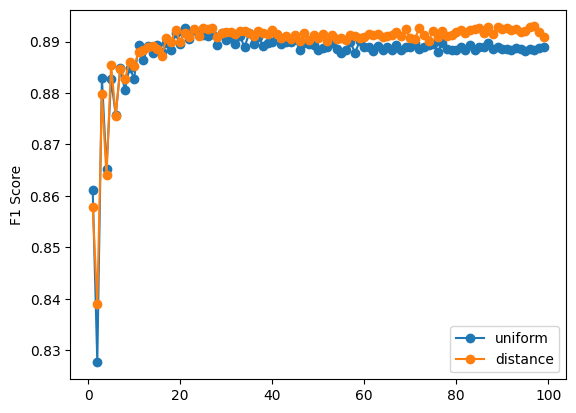

In [ ]:
cv = KFold(n_splits = 10, shuffle = True)

for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []
    for n_neighbors in range(1, 100):
        fold_f1_scores = []  # Changed variable name to reflect F1 scores
        knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        # Iterate through cross-validation splits
        for train_fold, test_fold in cv.split(train_set_vespa):
            # Split data
            f_train = train_set_vespa.loc[train_fold]
            f_test = train_set_vespa.loc[test_fold]
            # Train and predict
            knn.fit(X=f_train.drop(['VESPA_B'], axis=1), y=f_train['VESPA_B'])
            y_pred = knn.predict(X=f_test.drop(['VESPA_B'], axis=1))
            # Evaluate using F1 score
            f1 = f1_score(f_test['VESPA_B'], y_pred.round())  # Assuming rounding for classification
            fold_f1_scores.append(f1)
        total_scores.append(sum(fold_f1_scores) / len(fold_f1_scores))

    plt.plot(range(1, len(total_scores) + 1), total_scores, marker='o', label=weights)
    print('Max Value ' + weights + " : " + str(max(total_scores)) + " (" + str(np.argmax(total_scores) + 1) + ")")
    plt.ylabel('F1 Score')


plt.legend()
plt.show()

In [ ]:
# Resultado de la parametrización y elección de K's y peso
n_neighbors = 97
weights = 'distance'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights)

# fit, estimación y resultado
knn.fit( X = train_set_vespa.drop(['VESPA_B'], axis=1), y = train_set_vespa['VESPA_B'])
y_pred_vespa_knn = knn.predict(X = test_set_vespa.drop(['VESPA_B'], axis = 1))
f1 = f1_score(test_set_vespa['VESPA_B'], y_pred_vespa_knn.round())
print ('F1', f1)

F1 0.8955061190110489


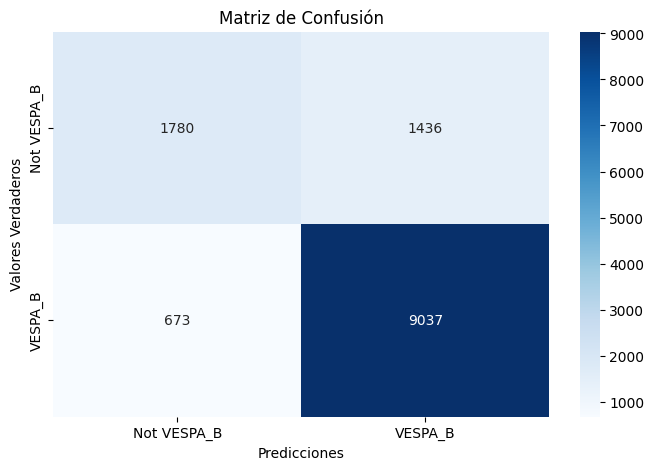

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_vespa['VESPA_B'], y_pred_vespa_knn.round())

# Visualización de la matriz
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not VESPA_B', 'VESPA_B'], yticklabels=['Not VESPA_B', 'VESPA_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


###Modelo 2 Random Forest - VESPA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Modelo clasificador
classifier = RandomForestClassifier()

def report(results, n_top=3):  # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Parameters: {0}".format(results['params'][candidate]))
            # Agregando la impresión del F1 score
            print("Mean F1 score: {0:.5f}".format(results['mean_test_score'][candidate]))
            print("")

# Hiperparametrización
param_dist = {
    "n_estimators": [32, 64, 128],  # Number of trees in random forest
    "max_features": ['log2', 'sqrt'],  # Number of features to consider at every split
    "max_depth": [24, 16, 8],  # Maximum number of levels in tree
    "min_samples_split": [2, 4, 6],  # Minimum number of samples required to split a node
    "min_samples_leaf": [8, 12, 16],  # Minimum number of samples required at each leaf node
    "bootstrap": [True, False]  # Method of selecting samples for training each tree
}

# Configurar GridSearchCV para usar el F1 score como métrica
f1_scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_dist, cv=5, scoring=f1_scorer, n_jobs=-1)

# Suponiendo que 'train_set_vespa' es tu conjunto de entrenamiento
grid_search.fit(X=train_set_vespa.drop(['VESPA_B'], axis=1), y=train_set_vespa['VESPA_B'])

# Mostrar mejores resultados
report(grid_search.cv_results_)


Model with rank: 1
Parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 128}
Mean F1 score: 0.89674

Model with rank: 2
Parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 32}
Mean F1 score: 0.89654

Model with rank: 3
Parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 64}
Mean F1 score: 0.89643



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

# Hiperparámetros elegidos
classifier = RandomForestClassifier(n_estimators=128, max_depth=8, max_features='log2', min_samples_leaf=8, min_samples_split=4)

# Entrenamiento
classifier.fit(X=train_set_vespa.drop(['VESPA_B'], axis=1), y=train_set_vespa['VESPA_B'])

# Predicción
y_pred_vespa_rf = classifier.predict(X=test_set_vespa.drop(['VESPA_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(test_set_vespa['VESPA_B'], y_pred_vespa_rf, pos_label=1)  # clasificación binaria

print("F1 Score:", f1)



F1 Score: 0.8987644674512867


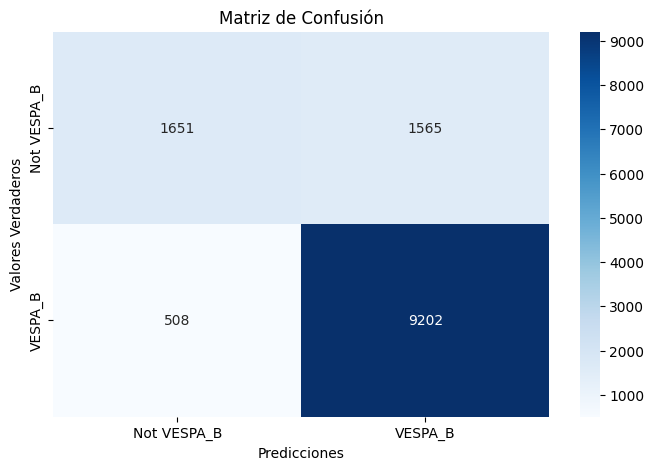

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_vespa_rf = y_pred_vespa_rf.round()

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_vespa['VESPA_B'], y_pred_vespa_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not VESPA_B', 'VESPA_B'], yticklabels=['Not VESPA_B', 'VESPA_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


###Modelo 3 AdaBoost - VESPA


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Definición de hiperparámetros
param_dist = {
    "n_estimators": [8, 16, 32, 64, 128],
    "learning_rate": [0.01, 0.05, 0.1],
    # 'loss' no es un parámetro en AdaBoostClassifier, por lo que se omite
}

# Creación del modelo AdaBoost con un DecisionTreeClassifier como base
grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy')),
                        param_grid=param_dist, cv=5, scoring='f1')

# Entrenamiento del modelo con el conjunto de entrenamiento
grid_ada.fit(X=train_set_vespa.drop(['VESPA_B'], axis=1), y=train_set_vespa['VESPA_B'])

# Mejor modelo encontrado
best_ada = grid_ada.best_estimator_
print(best_ada)


AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=0.1, n_estimators=128)


In [ ]:
# Entrenamiento y predicción con el mejor modelo
best_ada.fit(X=train_set_vespa.drop(['VESPA_B'], axis=1), y=train_set_vespa['VESPA_B'])
y_pred_vespa_ada = best_ada.predict(X=test_set_vespa.drop(['VESPA_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(test_set_vespa['VESPA_B'], y_pred_vespa_ada, pos_label=1)
print('F1 Score:', f1)



F1 Score: 0.8966778722562784


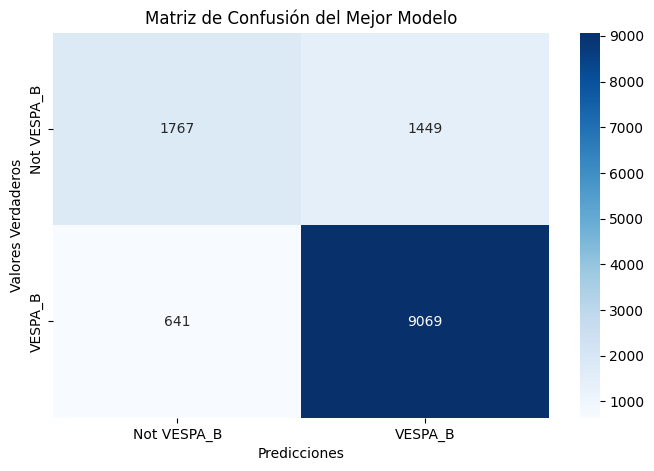

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_vespa_ada = y_pred_vespa_ada.round()

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_vespa['VESPA_B'], y_pred_vespa_ada)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not VESPA_B', 'VESPA_B'], yticklabels=['Not VESPA_B', 'VESPA_B'])
plt.title('Matriz de Confusión del Mejor Modelo')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


###Modelo 4 Regresion Logistica - VESPA

In [ ]:
# Conjunto de datos de entrenamiento
X_train_vespa = train_set_vespa.drop("VESPA_B", axis=1)
y_train_vespa = train_set_vespa["VESPA_B"].copy()

# Conjunto de datos de pruebas
X_test_vespa = test_set_vespa.drop("VESPA_B", axis=1)
y_test_vespa = test_set_vespa["VESPA_B"].copy()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenamos un algoritmo basado en regresión logística
clf = LogisticRegression(solver="newton-cg", max_iter=1000)
clf.fit(X_train_vespa, y_train_vespa)

# Realizamos predicciones con el conjunto de prueba
y_pred_vespa_rl = clf.predict(X_test_vespa)

from sklearn.metrics import f1_score
print("F1 score:", f1_score(y_test_vespa, y_pred_vespa_rl, pos_label=1))

F1 score: 0.887311786707586


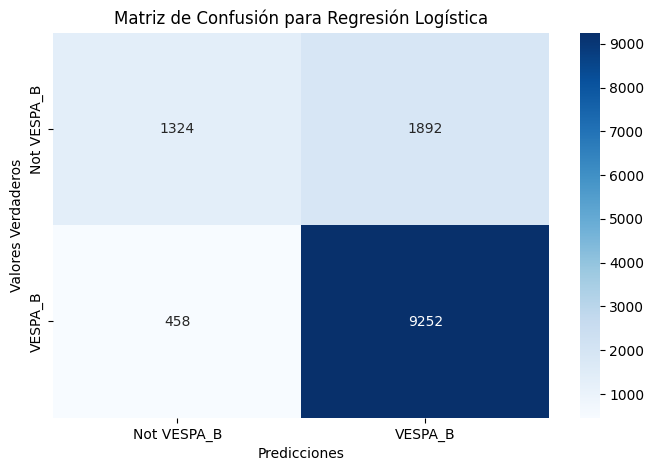

In [ ]:
# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_vespa, y_pred_vespa_rl)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not VESPA_B', 'VESPA_B'], yticklabels=['Not VESPA_B', 'VESPA_B'])
plt.title('Matriz de Confusión para Regresión Logística')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

Curvas ROC Y PR

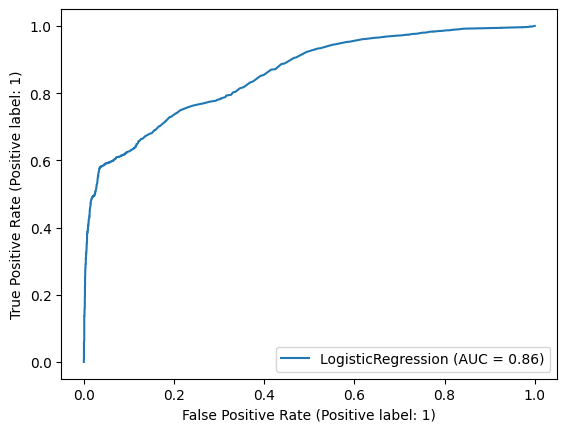

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test_vespa, y_test_vespa)

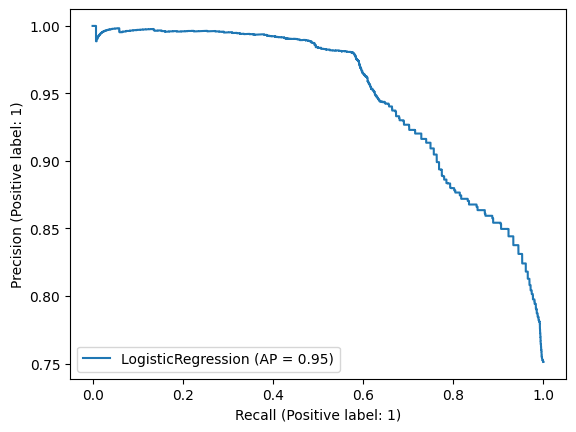

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf, X_test_vespa, y_test_vespa)

###Modelo 5 Arbol de decisión - VESPA

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Configuración de los hiperparámetros a probar
param_grid = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Inicialización del clasificador de árbol de decisión
clf_tree = DecisionTreeClassifier(random_state=42)

# Creación del objeto GridSearchCV
grid_search = GridSearchCV(estimator=clf_tree, param_grid=param_grid, scoring=make_scorer(f1_score, average='weighted'), cv=5)

# Ajuste de GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train_vespa, y_train_vespa)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Mejor modelo encontrado por GridSearchCV
best_tree = grid_search.best_estimator_


Mejores hiperparámetros: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [ ]:
# Predicción con el conjunto de entrenamiento usando el mejor modelo
y_pred_vespa_dt = best_tree.predict(X_test_vespa)

# Cálculo del F1 Score para el conjunto de entrenamiento
print("F1 Score Test Set:", f1_score(y_test_vespa, y_pred_vespa_dt, pos_label=1))

F1 Score Test Set: 0.8973763525865902


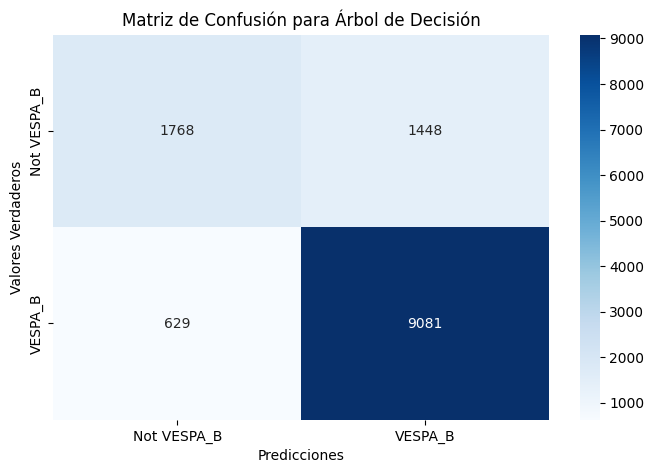

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicción con el conjunto de prueba
y_pred_vespa_rf = best_tree.predict(X_test_vespa)

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_vespa, y_pred_vespa_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not VESPA_B', 'VESPA_B'], yticklabels=['Not VESPA_B', 'VESPA_B'])
plt.title('Matriz de Confusión para Árbol de Decisión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


###Resultados de los modelos - Servicio VESPA





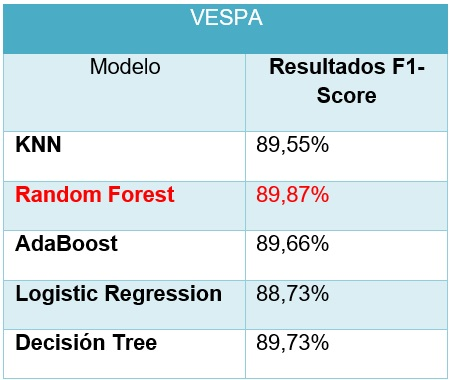

### SERVICIO ENFERMERIA

###Preparación del modelo

In [ ]:
# Se escoge base de entrenamiento y validacion
columnas_selecenf = ['INTERVENCIONES_B', 'EDAD_ACTUAL', 'NUTRICION_B', 'VALORACIONES_B', 'TERAPIA_OCUPACIONAL_B', 'VESPA_B', 'PLAN_DE_INTERVENCION_B', 'ODONTOLOGIA_B', 'CASO_JURIDICO_B', 'ATENCION_ENFERMERIA_B' ]
idipron_enf = idipron_final[columnas_selecenf]


In [ ]:
train_set_enf, test_set_enf = train_test_split(idipron_enf, test_size=0.3, random_state=42, stratify=idipron_enf["ATENCION_ENFERMERIA_B"])
train_set_enf.reset_index(drop=True, inplace=True)
test_set_enf.reset_index(drop=True, inplace=True)
train_set_enf.head(5)

,INTERVENCIONES_B,EDAD_ACTUAL,NUTRICION_B,VALORACIONES_B,TERAPIA_OCUPACIONAL_B,VESPA_B,PLAN_DE_INTERVENCION_B,ODONTOLOGIA_B,CASO_JURIDICO_B,ATENCION_ENFERMERIA_B
0,0,11.0,0,0,0,0,0,0,0,0
1,0,17.0,0,0,0,1,0,0,0,1
2,1,15.0,0,0,0,1,0,0,0,0
3,0,15.0,0,0,0,1,0,0,0,1
4,0,22.0,0,0,0,1,0,0,0,0


### Modelo 1 KNN - Enfermeria

Max Value uniform : 0.7896834028632405 (15)
Max Value distance : 0.7883405778970242 (31)


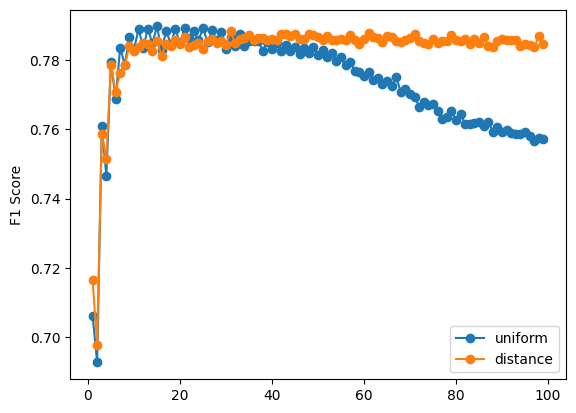

In [ ]:
cv = KFold(n_splits = 10, shuffle = True)

for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []
    for n_neighbors in range(1, 100):
        fold_f1_scores = []  # Changed variable name to reflect F1 scores
        knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        # Iterate through cross-validation splits
        for train_fold, test_fold in cv.split(train_set_enf):
            # Split data
            f_train = train_set_enf.loc[train_fold]
            f_test = train_set_enf.loc[test_fold]
            # Train and predict
            knn.fit(X=f_train.drop(['ATENCION_ENFERMERIA_B'], axis=1), y=f_train['ATENCION_ENFERMERIA_B'])
            y_pred = knn.predict(X=f_test.drop(['ATENCION_ENFERMERIA_B'], axis=1))
            # Evaluate using F1 score
            f1 = f1_score(f_test['ATENCION_ENFERMERIA_B'], y_pred.round())
            fold_f1_scores.append(f1)
        total_scores.append(sum(fold_f1_scores) / len(fold_f1_scores))

    plt.plot(range(1, len(total_scores) + 1), total_scores, marker='o', label=weights)
    print('Max Value ' + weights + " : " + str(max(total_scores)) + " (" + str(np.argmax(total_scores) + 1) + ")")
    plt.ylabel('F1 Score')


plt.legend()
plt.show()

In [ ]:
# Resultado de la parametrización y elección de K's y peso
n_neighbors = 15
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights)
# fit, estimación y resultado

knn.fit( X = train_set_enf.drop(['ATENCION_ENFERMERIA_B'], axis=1), y = train_set_enf['ATENCION_ENFERMERIA_B'])
y_pred_enf_knn = knn.predict(X = test_set_enf.drop(['ATENCION_ENFERMERIA_B'], axis = 1))
f1 = f1_score(test_set_enf['ATENCION_ENFERMERIA_B'], y_pred_enf_knn.round())
print ('F1', f1)

F1 0.7953626887896191


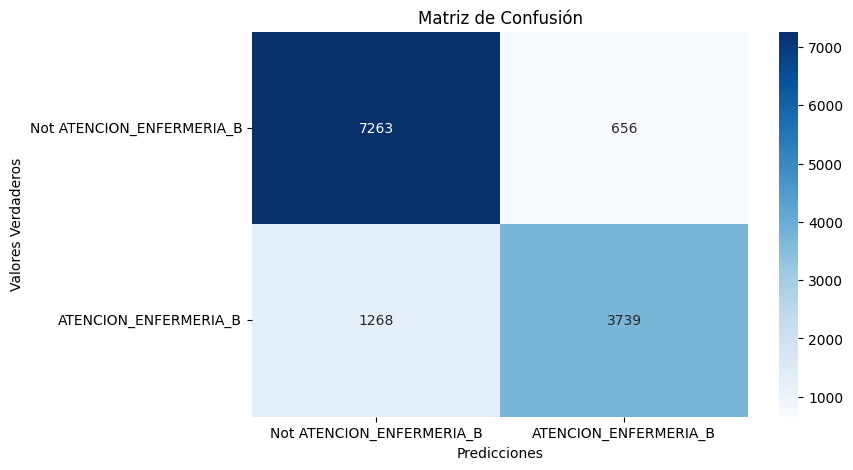

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_enf['ATENCION_ENFERMERIA_B'], y_pred_enf_knn.round())

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ATENCION_ENFERMERIA_B', 'ATENCION_ENFERMERIA_B'], yticklabels=['Not ATENCION_ENFERMERIA_B', 'ATENCION_ENFERMERIA_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


###Modelo 2 Random Forest - Enfermeria

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Cambiando el modelo a clasificador
classifier = RandomForestClassifier()

def report(results, n_top=3):  # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Parameters: {0}".format(results['params'][candidate]))
            # Agregando la impresión del F1 score
            print("Mean F1 score: {0:.5f}".format(results['mean_test_score'][candidate]))
            print("")

# Hiperparametrización
param_dist = {
    "n_estimators": [32, 64, 128],  # Number of trees in random forest
    "max_features": ['log2', 'sqrt'],  # Number of features to consider at every split
    "max_depth": [24, 16, 8],  # Maximum number of levels in tree
    "min_samples_split": [2, 4, 6],  # Minimum number of samples required to split a node
    "min_samples_leaf": [8, 12, 16],  # Minimum number of samples required at each leaf node
    "bootstrap": [True, False]  # Method of selecting samples for training each tree
}

# Configurar GridSearchCV para usar el F1 score como métrica
f1_scorer = make_scorer(f1_score, pos_label=0)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_dist, cv=5, scoring=f1_scorer, n_jobs=-1)

grid_search.fit(X=train_set_enf.drop(['ATENCION_ENFERMERIA_B'], axis=1), y=train_set_enf['ATENCION_ENFERMERIA_B'])

# Mostrar mejores resultados
report(grid_search.cv_results_)

Model with rank: 1
Parameters: {'bootstrap': False, 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 128}
Mean F1 score: 0.88587

Model with rank: 2
Parameters: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 64}
Mean F1 score: 0.88585

Model with rank: 3
Parameters: {'bootstrap': False, 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 16, 'min_samples_split': 6, 'n_estimators': 128}
Mean F1 score: 0.88584



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

# Hiperparámetros elegidos
classifier = RandomForestClassifier(n_estimators=128, max_depth=8, max_features='log2', min_samples_leaf=12, min_samples_split=2)

# Entrenamiento
classifier.fit(X=train_set_enf.drop(['ATENCION_ENFERMERIA_B'], axis=1), y=train_set_enf['ATENCION_ENFERMERIA_B'])

# Predicción
y_pred_enf_rf = classifier.predict(X=test_set_enf.drop(['ATENCION_ENFERMERIA_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(test_set_enf['ATENCION_ENFERMERIA_B'], y_pred_enf_rf, pos_label=0)

print("F1 Score:", f1)


F1 Score: 0.8878786017079314


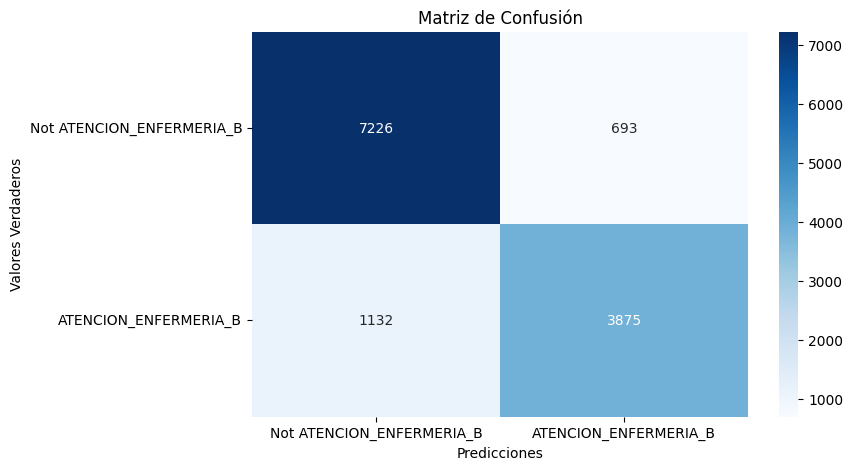

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_enf_rf = y_pred_enf_rf.round()

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_enf['ATENCION_ENFERMERIA_B'], y_pred_enf_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ATENCION_ENFERMERIA_B', 'ATENCION_ENFERMERIA_B'], yticklabels=['Not ATENCION_ENFERMERIA_B', 'ATENCION_ENFERMERIA_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 3 AdaBoost - Enfermeria

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Definición de hiperparámetros
param_dist = {
    "n_estimators": [8, 16, 32, 64, 128],
    "learning_rate": [0.01, 0.05, 0.1],
}

# Creación del modelo AdaBoost con un DecisionTreeClassifier como base
grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy')),
                        param_grid=param_dist, cv=5, scoring='f1')

# Entrenamiento del modelo con el conjunto de entrenamiento
grid_ada.fit(X=train_set_enf.drop(['ATENCION_ENFERMERIA_B'], axis=1), y=train_set_enf['ATENCION_ENFERMERIA_B'])

# Mejor modelo encontrado
best_ada = grid_ada.best_estimator_
print(best_ada)




AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=0.1, n_estimators=128)


In [ ]:
# Entrenamiento y predicción con el mejor modelo
best_ada.fit(X=train_set_enf.drop(['ATENCION_ENFERMERIA_B'], axis=1), y=train_set_enf['ATENCION_ENFERMERIA_B'])
y_pred_enf_ada = best_ada.predict(X=test_set_enf.drop(['ATENCION_ENFERMERIA_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(test_set_enf['ATENCION_ENFERMERIA_B'], y_pred_enf_ada, pos_label=0)  # Ajusta el promedio según tu caso
print('F1 Score:', f1)


F1 Score: 0.88103322823187


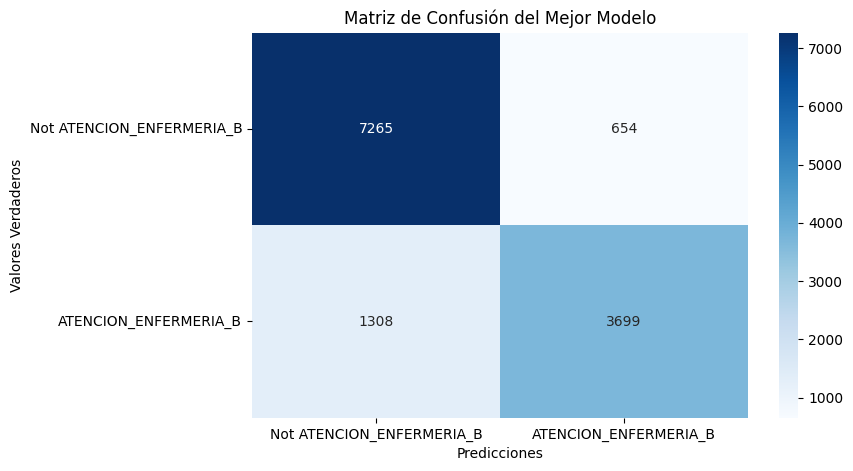

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_enf['ATENCION_ENFERMERIA_B'], y_pred_enf_ada)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ATENCION_ENFERMERIA_B', 'ATENCION_ENFERMERIA_B'], yticklabels=['Not ATENCION_ENFERMERIA_B', 'ATENCION_ENFERMERIA_B'])
plt.title('Matriz de Confusión del Mejor Modelo')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 4 Regresion Logistica - Enfermeria

In [ ]:
# Conjunto de datos de entrenamiento
X_train_enf = train_set_enf.drop("ATENCION_ENFERMERIA_B", axis=1)
y_train_enf = train_set_enf["ATENCION_ENFERMERIA_B"].copy()

# Conjunto de datos de pruebas
X_test_enf = test_set_enf.drop("ATENCION_ENFERMERIA_B", axis=1)
y_test_enf = test_set_enf["ATENCION_ENFERMERIA_B"].copy()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenamos un algoritmo basado en regresión logística
clf = LogisticRegression(solver="newton-cg", max_iter=1000)
clf.fit(X_train_enf, y_train_enf)

# Realizamos predicciones con el conjunto de prueba
y_pred_enf_rl = clf.predict(X_test_enf)

print("F1 score:", f1_score(y_test_enf, y_pred_enf_rl, pos_label=0))

F1 score: 0.8836652909863031


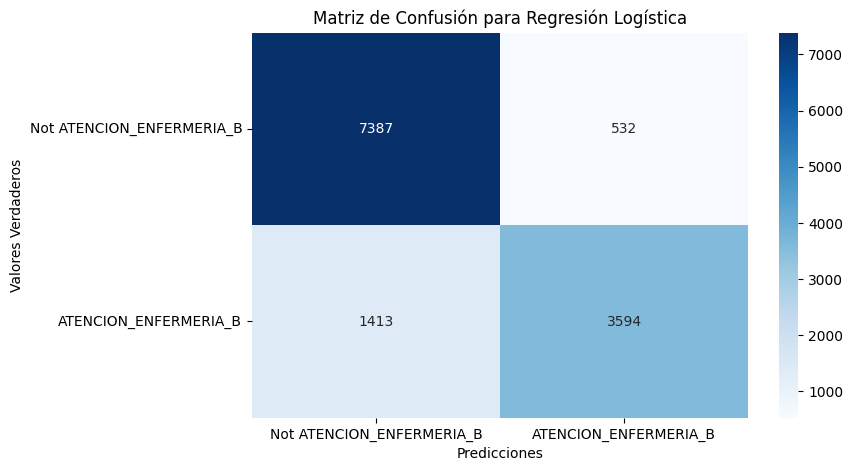

In [ ]:
# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_enf, y_pred_enf_rl)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ATENCION_ENFERMERIA_B', 'ATENCION_ENFERMERIA_B'], yticklabels=['Not ATENCION_ENFERMERIA_B', 'ATENCION_ENFERMERIA_B'])
plt.title('Matriz de Confusión para Regresión Logística')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

Curvas ROC Y PR

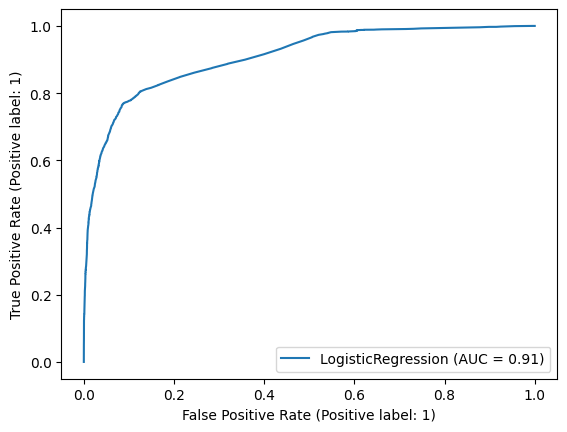

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test_enf, y_test_enf)

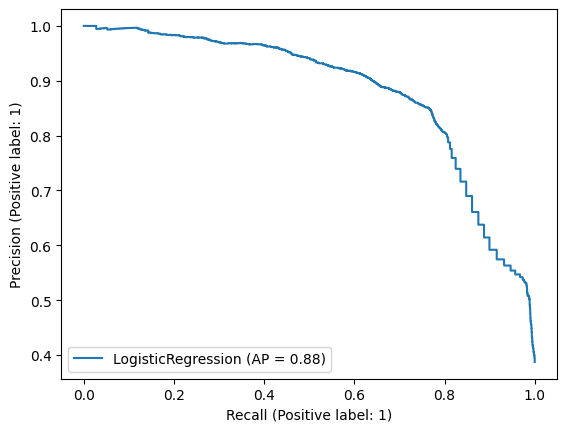

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf, X_test_enf, y_test_enf)

###Modelo 5 Arbol de decisión - Enfermeria

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Configuración de los hiperparámetros a probar
param_grid = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Inicialización del clasificador de árbol de decisión
clf_tree = DecisionTreeClassifier(random_state=42)

# Creación del objeto GridSearchCV
grid_search = GridSearchCV(estimator=clf_tree, param_grid=param_grid, scoring=make_scorer(f1_score, average='weighted'), cv=5)

# Ajuste de GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train_enf, y_train_enf)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Mejor modelo encontrado por GridSearchCV
best_tree = grid_search.best_estimator_

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [ ]:
# Predicción con el conjunto de entrenamiento usando el mejor modelo
y_pred_enf_dt = best_tree.predict(X_test_enf)

# Cálculo del F1 Score para el conjunto de entrenamiento
print("F1 Score Test Set:", f1_score(y_test_enf, y_pred_enf_dt, pos_label=0))

F1 Score Test Set: 0.8863913999511361


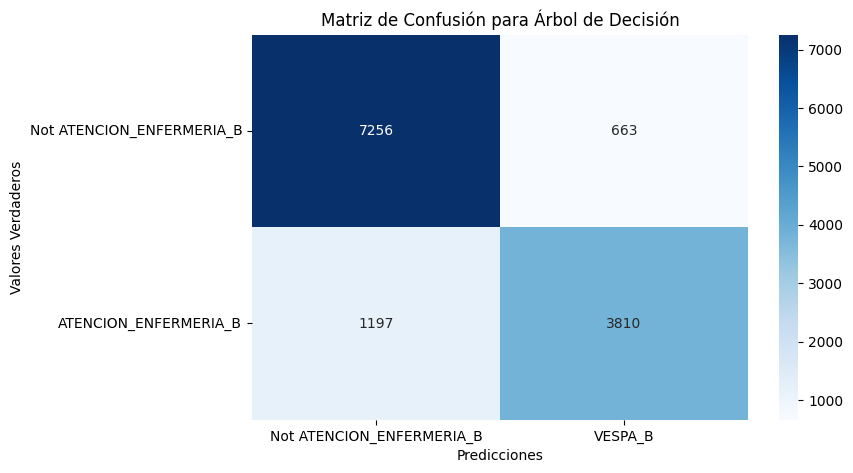

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_enf_rf = best_tree.predict(X_test_enf)

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_enf, y_pred_enf_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ATENCION_ENFERMERIA_B', 'VESPA_B'], yticklabels=['Not ATENCION_ENFERMERIA_B', 'ATENCION_ENFERMERIA_B'])
plt.title('Matriz de Confusión para Árbol de Decisión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Resultados de los modelos - Servicio Enfermeria

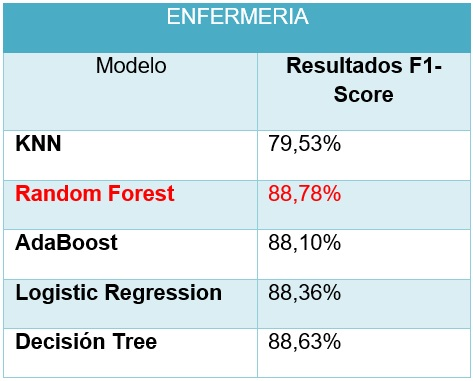

###SERVICIO INTERVENCIONES

###  Preparación del modelo

In [ ]:
## Escoger base de entrenamiento y validacion
columnas_selecinter = ['VALORACIONES_B', 'CONSULTAS_B', 'ATENCION_MEDICA_B', 'VESPA_B', 'ATENCION_MEDICA_B', 'NUTRICION_B', 'TERAPIA_OCUPACIONAL_B', 'ODONTOLOGIA_B', 'INTERVENCIONES_B']
idipron_inter = idipron_final[columnas_selecinter]


In [ ]:
train_set_inter, test_set_inter = train_test_split(idipron_inter, test_size=0.3, random_state=42, stratify=idipron_inter["INTERVENCIONES_B"])
train_set_inter.reset_index(drop=True, inplace=True)
test_set_inter.reset_index(drop=True, inplace=True)
train_set_inter.head(5)

,VALORACIONES_B,CONSULTAS_B,ATENCION_MEDICA_B,VESPA_B,ATENCION_MEDICA_B,NUTRICION_B,TERAPIA_OCUPACIONAL_B,ODONTOLOGIA_B,INTERVENCIONES_B
0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,0,0,1
2,1,0,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0


### Modelo 1 KNN - Intervenciones

Max Value uniform : 0.7869767890549207 (17)
Max Value distance : 0.7855741052615552 (87)


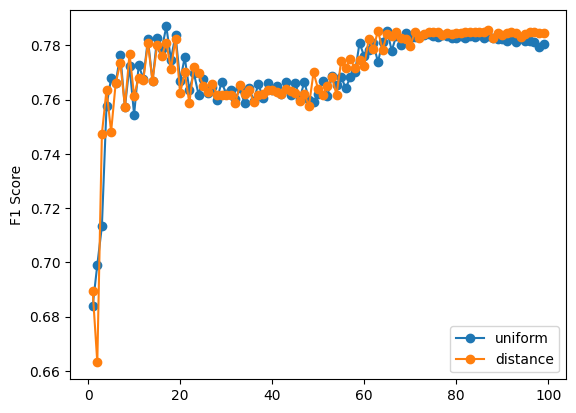

In [ ]:
cv = KFold(n_splits = 10, shuffle = True)

for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []
    for n_neighbors in range(1, 100):
        fold_f1_scores = []  # Changed variable name to reflect F1 scores
        knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        # Iterate through cross-validation splits
        for train_fold, test_fold in cv.split(train_set_inter):
            # Split data
            f_train = train_set_inter.loc[train_fold]
            f_test = train_set_inter.loc[test_fold]
            # Train and predict
            knn.fit(X=f_train.drop(['INTERVENCIONES_B'], axis=1), y=f_train['INTERVENCIONES_B'])
            y_pred = knn.predict(X=f_test.drop(['INTERVENCIONES_B'], axis=1))
            # Evaluate using F1 score
            f1 = f1_score(f_test['INTERVENCIONES_B'], y_pred.round())
            fold_f1_scores.append(f1)
        total_scores.append(sum(fold_f1_scores) / len(fold_f1_scores))

    plt.plot(range(1, len(total_scores) + 1), total_scores, marker='o', label=weights)
    print('Max Value ' + weights + " : " + str(max(total_scores)) + " (" + str(np.argmax(total_scores) + 1) + ")")
    plt.ylabel('F1 Score')


plt.legend()
plt.show()

In [ ]:
# Resultado de la parametrización y elección de K's y peso
n_neighbors = 17
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights)
# fit, estimación y resultado

knn.fit( X = train_set_inter.drop(['INTERVENCIONES_B'], axis=1), y = train_set_inter['INTERVENCIONES_B'])
y_pred_inter_knn = knn.predict(X = test_set_inter.drop(['INTERVENCIONES_B'], axis = 1))
f1 = f1_score(test_set_inter['INTERVENCIONES_B'], y_pred_inter_knn.round())
print ('F1', f1)

F1 0.7932522557865829


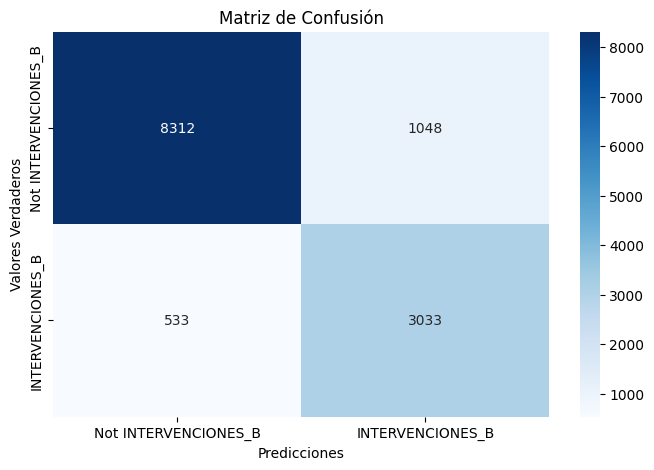

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_inter['INTERVENCIONES_B'], y_pred_inter_knn.round())

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not INTERVENCIONES_B', 'INTERVENCIONES_B'], yticklabels=['Not INTERVENCIONES_B', 'INTERVENCIONES_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 2 Random Forest - Intervenciones

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Cambiando el modelo a clasificador
classifier = RandomForestClassifier()

def report(results, n_top=3):  # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Parameters: {0}".format(results['params'][candidate]))
            # Agregando la impresión del F1 score
            print("Mean F1 score: {0:.5f}".format(results['mean_test_score'][candidate]))
            print("")

# Hiperparametrización
param_dist = {
    "n_estimators": [32, 64, 128],  # Number of trees in random forest
    "max_features": ['log2', 'sqrt'],  # Number of features to consider at every split
    "max_depth": [24, 16, 8],  # Maximum number of levels in tree
    "min_samples_split": [2, 4, 6],  # Minimum number of samples required to split a node
    "min_samples_leaf": [8, 12, 16],  # Minimum number of samples required at each leaf node
    "bootstrap": [True, False]  # Method of selecting samples for training each tree
}

# Configurar GridSearchCV para usar el F1 score como métrica
f1_scorer = make_scorer(f1_score, pos_label=0)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_dist, cv=5, scoring=f1_scorer, n_jobs=-1)

grid_search.fit(X=train_set_inter.drop(['INTERVENCIONES_B'], axis=1), y=train_set_inter['INTERVENCIONES_B'])

# Mostrar mejores resultados
report(grid_search.cv_results_)

Model with rank: 1
Parameters: {'bootstrap': True, 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 6, 'n_estimators': 32}
Mean F1 score: 0.92160

Model with rank: 2
Parameters: {'bootstrap': True, 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 6, 'n_estimators': 64}
Mean F1 score: 0.92158

Model with rank: 3
Parameters: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 6, 'n_estimators': 32}
Mean F1 score: 0.92158



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

# Hiperparámetros elegidos
classifier = RandomForestClassifier(n_estimators=32, max_depth=16, max_features='sqrt', min_samples_leaf=16, min_samples_split=6)

# Entrenamiento
classifier.fit(X=train_set_inter.drop(['INTERVENCIONES_B'], axis=1), y=train_set_inter['INTERVENCIONES_B'])

# Predicción
y_pred_inter_rf = classifier.predict(X=test_set_inter.drop(['INTERVENCIONES_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(test_set_inter['INTERVENCIONES_B'], y_pred_inter_rf, pos_label=0)

print("F1 Score:", f1)


F1 Score: 0.9234119396643298


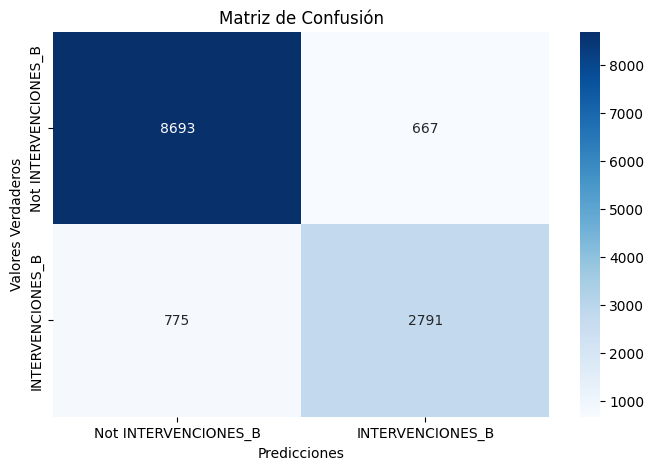

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_inter_rf = y_pred_inter_rf.round()  # Asegúrate de adaptar esta línea si y_pred no está en formato de clases

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_inter['INTERVENCIONES_B'], y_pred_inter_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not INTERVENCIONES_B', 'INTERVENCIONES_B'], yticklabels=['Not INTERVENCIONES_B', 'INTERVENCIONES_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


###Modelo 3 AdaBoost - Intervenciones

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Definición de hiperparámetros
param_dist = {
    "n_estimators": [8, 16, 32, 64, 128],
    "learning_rate": [0.01, 0.05, 0.1],
    # 'loss' no es un parámetro en AdaBoostClassifier, por lo que se omite
}

# Creación del modelo AdaBoost con un DecisionTreeClassifier como base
grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy')),
                        param_grid=param_dist, cv=5, scoring='f1')

# Entrenamiento del modelo con el conjunto de entrenamiento
grid_ada.fit(X=train_set_inter.drop(['INTERVENCIONES_B'], axis=1), y=train_set_inter['INTERVENCIONES_B'])

# Mejor modelo encontrado
best_ada = grid_ada.best_estimator_
print(best_ada)

AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=0.01, n_estimators=8)


In [ ]:
# Entrenamiento y predicción con el mejor modelo
best_ada.fit(X=train_set_inter.drop(['INTERVENCIONES_B'], axis=1), y=train_set_inter['INTERVENCIONES_B'])
y_pred_inter_ada = best_ada.predict(X=test_set_inter.drop(['INTERVENCIONES_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(test_set_inter['INTERVENCIONES_B'], y_pred_inter_ada, pos_label=0)
print('F1 Score:', f1)


F1 Score: 0.9234693877551021


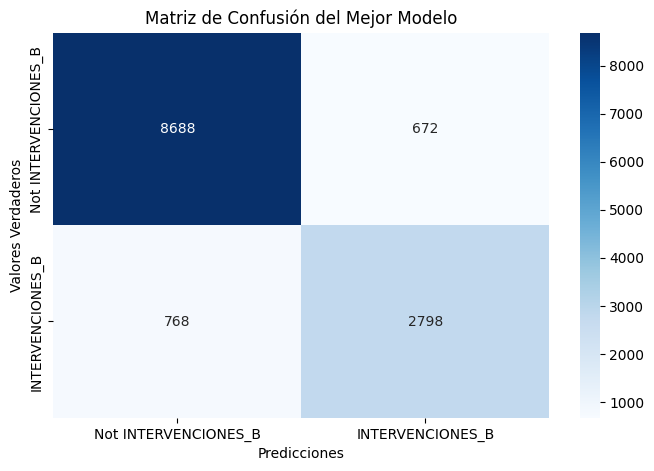

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_inter_ada = y_pred_inter_ada.round()

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_inter['INTERVENCIONES_B'], y_pred_inter_ada)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not INTERVENCIONES_B', 'INTERVENCIONES_B'], yticklabels=['Not INTERVENCIONES_B', 'INTERVENCIONES_B'])
plt.title('Matriz de Confusión del Mejor Modelo')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 4 Regresion Logistica - Intervenciones

In [ ]:
# Conjunto de datos de entrenamiento
X_train_inter = train_set_inter.drop("INTERVENCIONES_B", axis=1)
y_train_inter = train_set_inter["INTERVENCIONES_B"].copy()

# Conjunto de datos de pruebas
X_test_inter = test_set_inter.drop("INTERVENCIONES_B", axis=1)
y_test_inter = test_set_inter["INTERVENCIONES_B"].copy()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenamos un algoritmo basado en regresión logística
clf = LogisticRegression(solver="newton-cg", max_iter=1000)
clf.fit(X_train_inter, y_train_inter)

# Realizamos predicciones con el conjunto de prueba
y_pred_inter_rl = clf.predict(X_test_inter)

In [ ]:
from sklearn.metrics import f1_score
print("F1 score:", f1_score(y_test_inter, y_pred_inter_rl, pos_label=0))

F1 score: 0.9235163440177722


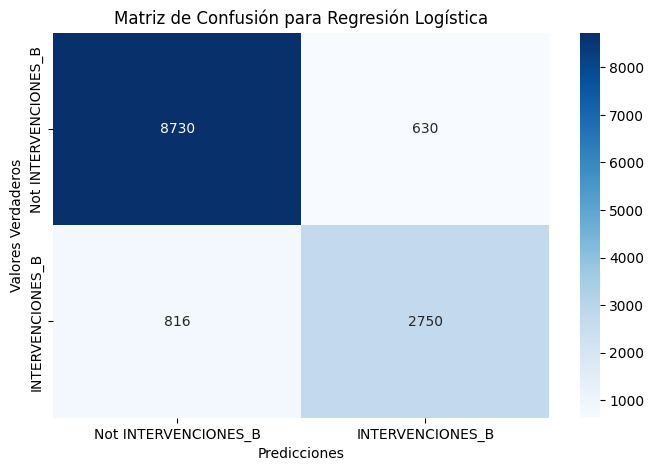

In [ ]:
# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_inter, y_pred_inter_rl)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not INTERVENCIONES_B', 'INTERVENCIONES_B'], yticklabels=['Not INTERVENCIONES_B', 'INTERVENCIONES_B'])
plt.title('Matriz de Confusión para Regresión Logística')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

Curvas ROC Y PR

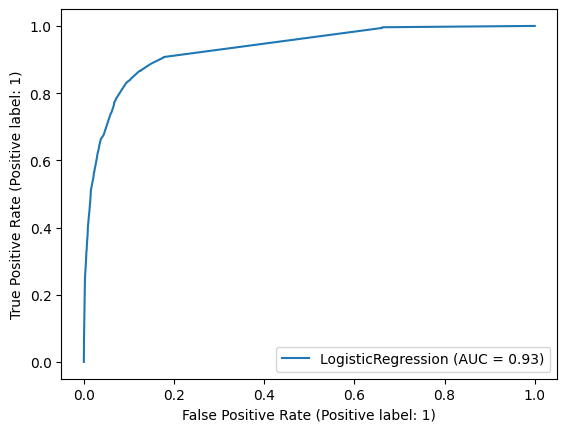

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test_inter, y_test_inter)

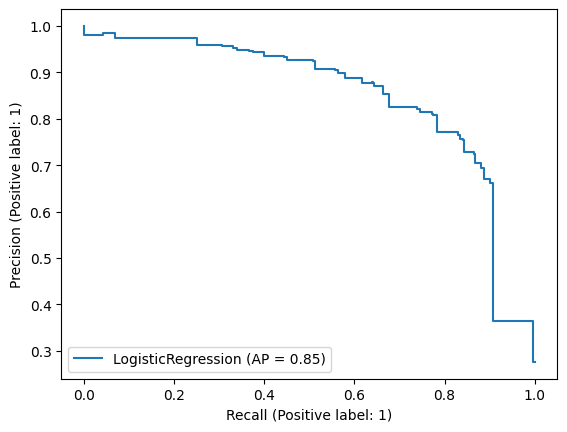

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf, X_test_inter, y_test_inter)

###Modelo 5 Arbol de decisión - Intervenciones

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Configuración de los hiperparámetros a probar
param_grid = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Inicialización del clasificador de árbol de decisión
clf_tree = DecisionTreeClassifier(random_state=42)

# Creación del objeto GridSearchCV
grid_search = GridSearchCV(estimator=clf_tree, param_grid=param_grid, scoring=make_scorer(f1_score, average='weighted'), cv=5)

# Ajuste de GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train_inter, y_train_inter)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Mejor modelo encontrado por GridSearchCV
best_tree = grid_search.best_estimator_

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [ ]:
# Predicción con el conjunto de entrenamiento usando el mejor modelo
y_pred_inter_dt = best_tree.predict(X_test_inter)

# Cálculo del F1 Score para el conjunto de entrenamiento
print("F1 Score Test Set:", f1_score(y_test_inter, y_pred_inter_dt, pos_label=0))

F1 Score Test Set: 0.9234612522589561


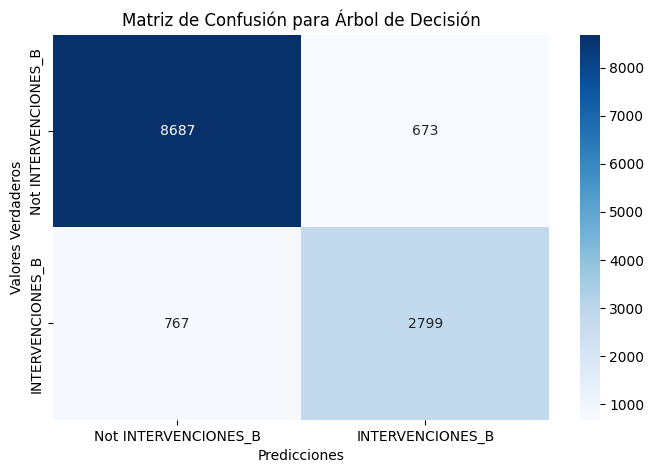

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_inter_rf = best_tree.predict(X_test_inter)

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_inter, y_pred_inter_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not INTERVENCIONES_B', 'INTERVENCIONES_B'], yticklabels=['Not INTERVENCIONES_B', 'INTERVENCIONES_B'])
plt.title('Matriz de Confusión para Árbol de Decisión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Resultados de los modelos - Servicio Intervenciones

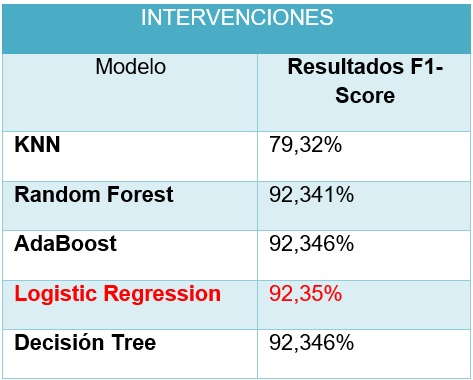

### SERVICIO NUTRICIÓN

### Preparación del modelo

In [ ]:
## Escoger base de entrenamiento y validacion
columnas_selecnut = ['EDAD_ACTUAL', 'INTERVENCIONES_B', 'ATENCION_ENFERMERIA_B', 'ODONTOLOGIA_B', 'VESPA_B', 'VALORACIONES_B', 'TERAPIA_OCUPACIONAL_B', 'ESTRATO', 'PLAN_DE_INTERVENCION_B', 'NUTRICION_B']
idipron_nut = idipron_final[columnas_selecnut]


In [ ]:
train_set_nut, test_set_nut = train_test_split(idipron_nut, test_size=0.3, random_state=42, stratify=idipron_nut["NUTRICION_B"])
train_set_nut.reset_index(drop=True, inplace=True)
test_set_nut.reset_index(drop=True, inplace=True)
train_set_nut.head(5)

,EDAD_ACTUAL,INTERVENCIONES_B,ATENCION_ENFERMERIA_B,ODONTOLOGIA_B,VESPA_B,VALORACIONES_B,TERAPIA_OCUPACIONAL_B,ESTRATO,PLAN_DE_INTERVENCION_B,NUTRICION_B
0,27.0,0,0,0,1,0,0,1,0,0
1,27.0,0,0,0,1,0,0,2,0,0
2,20.0,1,1,0,1,1,1,2,1,1
3,20.0,0,1,0,1,0,0,2,0,0
4,29.0,0,1,0,1,0,0,1,0,0


### Modelo 1 KNN - Nutrición


Max Value uniform : 0.6764909718658375 (15)
Max Value distance : 0.6665935151327563 (21)


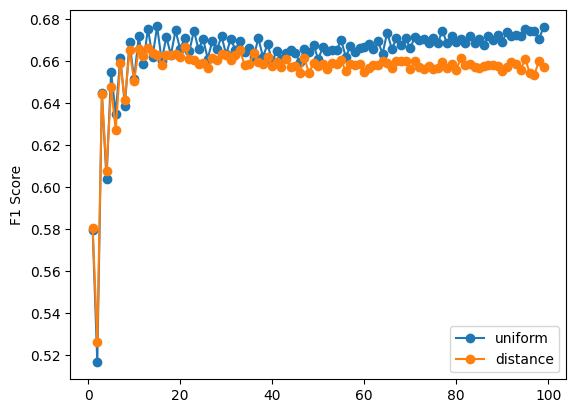

In [ ]:
cv = KFold(n_splits = 10, shuffle = True)

for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []
    for n_neighbors in range(1, 100):
        fold_f1_scores = []  # Changed variable name to reflect F1 scores
        knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        # Iterate through cross-validation splits
        for train_fold, test_fold in cv.split(train_set_nut):
            # Split data
            f_train = train_set_nut.loc[train_fold]
            f_test = train_set_nut.loc[test_fold]
            # Train and predict
            knn.fit(X=f_train.drop(['NUTRICION_B'], axis=1), y=f_train['NUTRICION_B'])
            y_pred = knn.predict(X=f_test.drop(['NUTRICION_B'], axis=1))
            # Evaluate using F1 score
            f1 = f1_score(f_test['NUTRICION_B'], y_pred.round())
            fold_f1_scores.append(f1)
        total_scores.append(sum(fold_f1_scores) / len(fold_f1_scores))

    plt.plot(range(1, len(total_scores) + 1), total_scores, marker='o', label=weights)
    print('Max Value ' + weights + " : " + str(max(total_scores)) + " (" + str(np.argmax(total_scores) + 1) + ")")
    plt.ylabel('F1 Score')


plt.legend()
plt.show()

In [ ]:
# Resultado de la parametrización y elección de K's y peso
n_neighbors = 15
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights)
# fit, estimación y resultado

knn.fit( X = train_set_nut.drop(['NUTRICION_B'], axis=1), y = train_set_nut['NUTRICION_B'])
y_pred_nut_knn = knn.predict(X = test_set_nut.drop(['NUTRICION_B'], axis = 1))
f1 = f1_score(test_set_nut['NUTRICION_B'], y_pred_nut_knn.round())
print ('F1', f1)

F1 0.6753143085212533


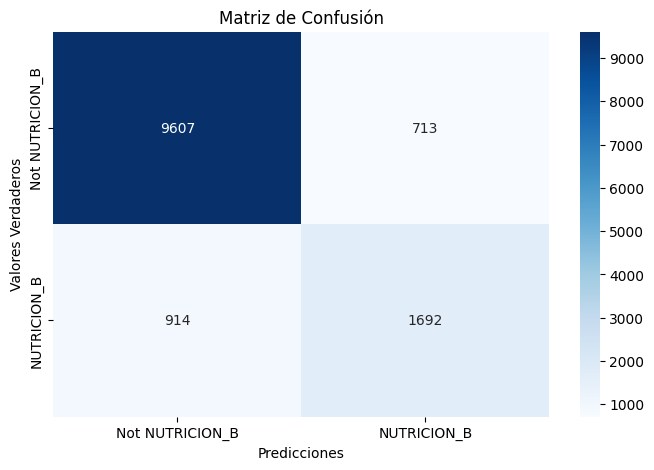

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_nut['NUTRICION_B'], y_pred_nut_knn.round())

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not NUTRICION_B', 'NUTRICION_B'], yticklabels=['Not NUTRICION_B', 'NUTRICION_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


###Modelo 2 Random Forest - Nutrición

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Cambiando el modelo a clasificador
classifier = RandomForestClassifier()

def report(results, n_top=3):  # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Parameters: {0}".format(results['params'][candidate]))
            # Agregando la impresión del F1 score
            print("Mean F1 score: {0:.5f}".format(results['mean_test_score'][candidate]))
            print("")

# Hiperparametrización
param_dist = {
    "n_estimators": [32, 64, 128],  # Number of trees in random forest
    "max_features": ['log2', 'sqrt'],  # Number of features to consider at every split
    "max_depth": [24, 16, 8],  # Maximum number of levels in tree
    "min_samples_split": [2, 4, 6],  # Minimum number of samples required to split a node
    "min_samples_leaf": [8, 12, 16],  # Minimum number of samples required at each leaf node
    "bootstrap": [True, False]  # Method of selecting samples for training each tree
}

# Configurar GridSearchCV para usar el F1 score como métrica
f1_scorer = make_scorer(f1_score, pos_label=0)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_dist, cv=5, scoring=f1_scorer, n_jobs=-1)

grid_search.fit(X=train_set_nut.drop(['NUTRICION_B'], axis=1), y=train_set_nut['NUTRICION_B'])

# Mostrar mejores resultados
report(grid_search.cv_results_)

Model with rank: 1
Parameters: {'bootstrap': True, 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 4, 'n_estimators': 32}
Mean F1 score: 0.92525

Model with rank: 2
Parameters: {'bootstrap': True, 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 64}
Mean F1 score: 0.92494

Model with rank: 3
Parameters: {'bootstrap': True, 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 6, 'n_estimators': 32}
Mean F1 score: 0.92492



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

# Hiperparámetros elegidos
classifier = RandomForestClassifier(n_estimators=32, max_depth=16, max_features='sqrt', min_samples_leaf=16, min_samples_split=4)

# Entrenamiento
classifier.fit(X=train_set_nut.drop(['NUTRICION_B'], axis=1), y=train_set_nut['NUTRICION_B'])

# Predicción
y_pred_nut_rf = classifier.predict(X=test_set_nut.drop(['NUTRICION_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(test_set_nut['NUTRICION_B'], y_pred_nut_rf, pos_label=0)

print("F1 Score:", f1)

F1 Score: 0.9243016355478362


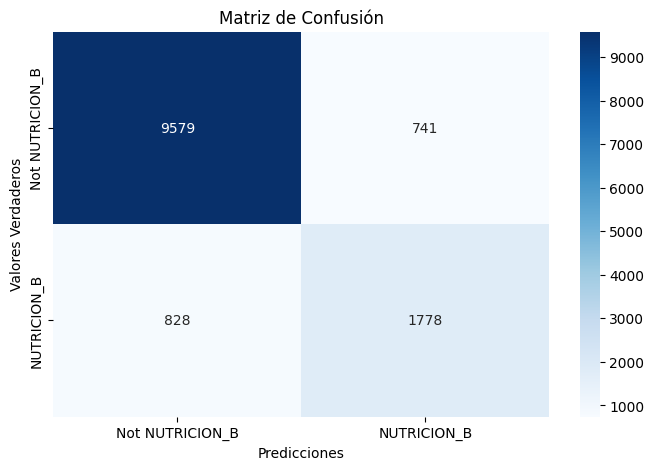

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_nut_rf = y_pred_nut_rf.round()

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_nut['NUTRICION_B'], y_pred_nut_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not NUTRICION_B', 'NUTRICION_B'], yticklabels=['Not NUTRICION_B', 'NUTRICION_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


###Modelo 3 AdaBoost - Nutrición

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Definición de hiperparámetros
param_dist = {
    "n_estimators": [8, 16, 32, 64, 128],
    "learning_rate": [0.01, 0.05, 0.1],
    # 'loss' no es un parámetro en AdaBoostClassifier, por lo que se omite
}

# Creación del modelo AdaBoost con un DecisionTreeClassifier como base
grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy')),
                        param_grid=param_dist, cv=5, scoring='f1')

# Entrenamiento del modelo con el conjunto de entrenamiento
grid_ada.fit(X=train_set_nut.drop(['NUTRICION_B'], axis=1), y=train_set_nut['NUTRICION_B'])

# Mejor modelo encontrado
best_ada = grid_ada.best_estimator_
print(best_ada)



AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=0.1, n_estimators=128)


In [ ]:
# Entrenamiento y predicción con el mejor modelo
best_ada.fit(X=train_set_nut.drop(['NUTRICION_B'], axis=1), y=train_set_nut['NUTRICION_B'])
y_pred_nut_ada = best_ada.predict(X=test_set_nut.drop(['NUTRICION_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(test_set_nut['NUTRICION_B'], y_pred_nut_ada, pos_label=0)
print('F1 Score:', f1)


F1 Score: 0.9192952134043881


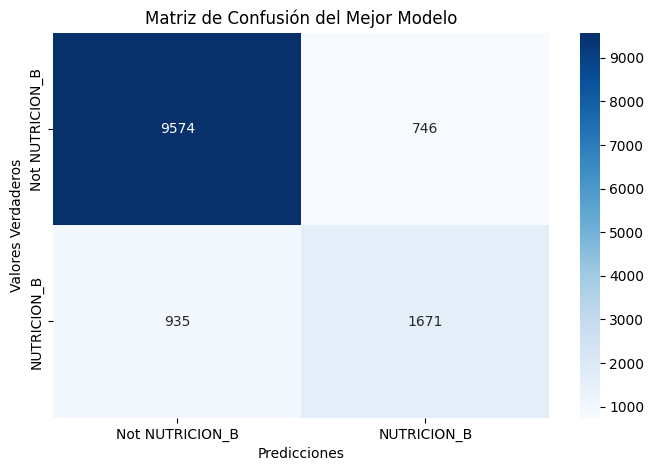

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_nut_ada = y_pred_nut_ada.round()

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_nut['NUTRICION_B'], y_pred_nut_ada)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not NUTRICION_B', 'NUTRICION_B'], yticklabels=['Not NUTRICION_B', 'NUTRICION_B'])
plt.title('Matriz de Confusión del Mejor Modelo')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 4 Regresion Logistica - Nutrición

In [ ]:
  # Conjunto de datos de entrenamiento
  X_train_nut = train_set_nut.drop("NUTRICION_B", axis=1)
  y_train_nut = train_set_nut["NUTRICION_B"].copy()

  # Conjunto de datos de pruebas
  X_test_nut = test_set_nut.drop("NUTRICION_B", axis=1)
  y_test_nut = test_set_nut["NUTRICION_B"].copy()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenamos un algoritmo basado en regresión logística
clf = LogisticRegression(solver="newton-cg", max_iter=1000)
clf.fit(X_train_nut, y_train_nut)

# Realizamos predicciones con el conjunto de prueba
y_pred_nut_rl = clf.predict(X_test_nut)

In [ ]:
from sklearn.metrics import f1_score
print("F1 score:", f1_score(y_test_nut, y_pred_nut_rl, pos_label=0))

F1 score: 0.9223366374747377


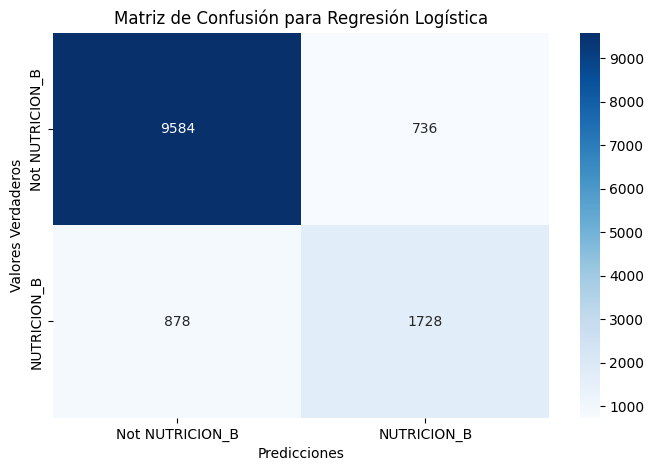

In [ ]:
# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_nut, y_pred_nut_rl)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not NUTRICION_B', 'NUTRICION_B'], yticklabels=['Not NUTRICION_B', 'NUTRICION_B'])
plt.title('Matriz de Confusión para Regresión Logística')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

Curvas ROC y PR

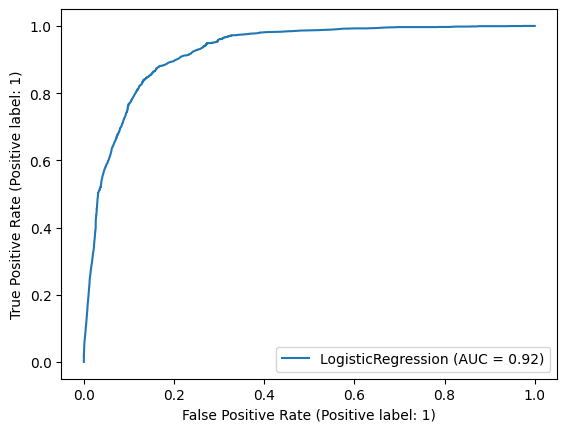

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test_nut, y_test_nut)

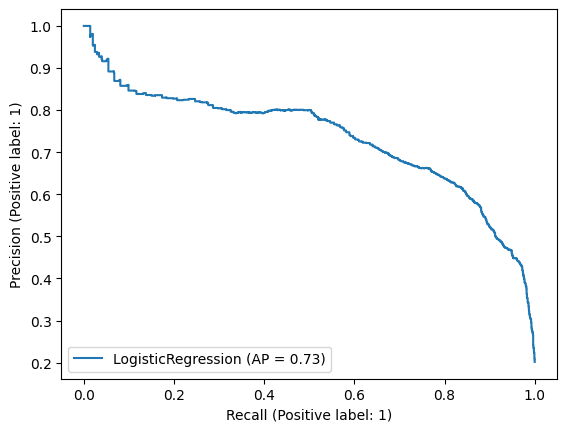

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf, X_test_nut, y_test_nut)

###Modelo 5 Arbol de decisión - Nutrición

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Configuración de los hiperparámetros a probar
param_grid = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Inicialización del clasificador de árbol de decisión
clf_tree = DecisionTreeClassifier(random_state=42)

# Creación del objeto GridSearchCV
grid_search = GridSearchCV(estimator=clf_tree, param_grid=param_grid, scoring=make_scorer(f1_score, average='weighted'), cv=5)

# Ajuste de GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train_nut, y_train_nut)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Mejor modelo encontrado por GridSearchCV
best_tree = grid_search.best_estimator_

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [ ]:
# Predicción con el conjunto de entrenamiento usando el mejor modelo
y_pred_nut_dt = best_tree.predict(X_test_nut)

# Cálculo del F1 Score para el conjunto de entrenamiento
print("F1 Score Test Set:", f1_score(y_test_nut, y_pred_nut_dt, pos_label=0))

F1 Score Test Set: 0.9228027931615699


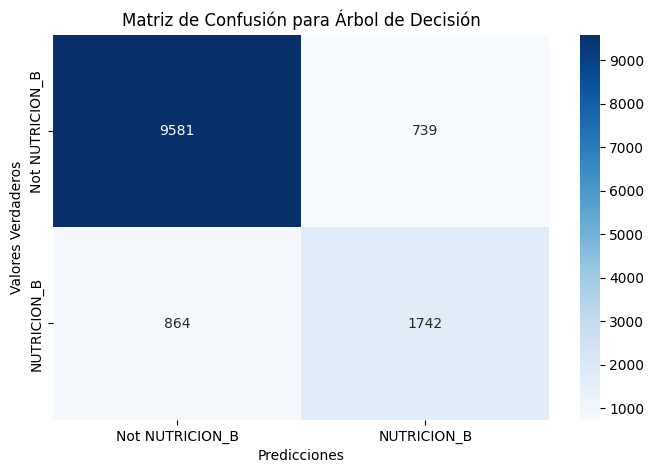

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicción con el conjunto de prueba
y_pred_nut_rf = best_tree.predict(X_test_nut)

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_nut, y_pred_nut_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not NUTRICION_B', 'NUTRICION_B'], yticklabels=['Not NUTRICION_B', 'NUTRICION_B'])
plt.title('Matriz de Confusión para Árbol de Decisión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


###Resultados de los modelos - Servicio Nutrición

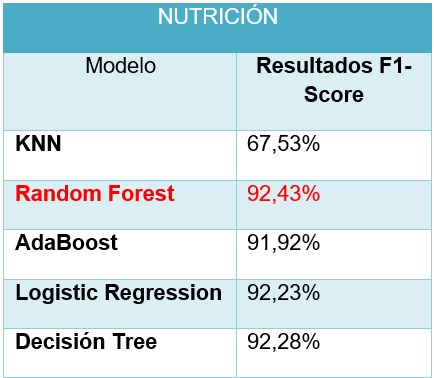

### SERVICIO TERAPIA OCUPACIONAL

### Preparación del modelo

In [ ]:
## Escoger base de entrenamiento y validacion
columnas_selecter = ['PLAN_DE_INTERVENCION_B', 'EDAD_ACTUAL', 'NUTRICION_B', 'ODONTOLOGIA_B', 'ATENCION_ENFERMERIA_B', 'VALORACIONES_B', 'INTERVENCIONES_B', 'ESTRATO', 'TERAPIA_OCUPACIONAL_B']
idipron_ter = idipron_final[columnas_selecter]


In [ ]:
train_set_ter, test_set_ter = train_test_split(idipron_ter, test_size=0.3, random_state=42, stratify=idipron_ter["TERAPIA_OCUPACIONAL_B"])
train_set_ter.reset_index(drop=True, inplace=True)
test_set_ter.reset_index(drop=True, inplace=True)
train_set_ter.head(5)

,PLAN_DE_INTERVENCION_B,EDAD_ACTUAL,NUTRICION_B,ODONTOLOGIA_B,ATENCION_ENFERMERIA_B,VALORACIONES_B,INTERVENCIONES_B,ESTRATO,TERAPIA_OCUPACIONAL_B
0,0,27.0,0,0,1,0,1,2,0
1,0,20.0,0,0,0,0,0,1,0
2,0,24.0,0,0,0,0,0,1,0
3,0,14.0,0,0,1,0,0,1,0
4,0,14.0,0,0,0,0,0,2,0


### Modelo 1 KNN - Terapia Ocupacional

Max Value uniform : 0.7603149355593043 (86)
Max Value distance : 0.741711451383087 (39)


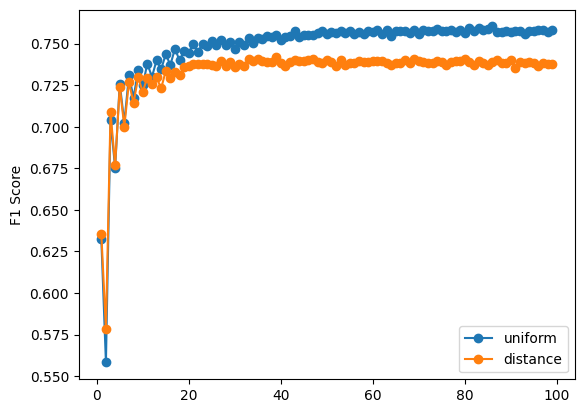

In [ ]:
cv = KFold(n_splits = 10, shuffle = True)

for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []
    for n_neighbors in range(1, 100):
        fold_f1_scores = []  # Changed variable name to reflect F1 scores
        knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        # Iterate through cross-validation splits
        for train_fold, test_fold in cv.split(train_set_ter):
            # Split data
            f_train = train_set_ter.loc[train_fold]
            f_test = train_set_ter.loc[test_fold]
            # Train and predict
            knn.fit(X=f_train.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), y=f_train['TERAPIA_OCUPACIONAL_B'])
            y_pred = knn.predict(X=f_test.drop(['TERAPIA_OCUPACIONAL_B'], axis=1))
            # Evaluate using F1 score
            f1 = f1_score(f_test['TERAPIA_OCUPACIONAL_B'], y_pred.round())
            fold_f1_scores.append(f1)
        total_scores.append(sum(fold_f1_scores) / len(fold_f1_scores))

    plt.plot(range(1, len(total_scores) + 1), total_scores, marker='o', label=weights)
    print('Max Value ' + weights + " : " + str(max(total_scores)) + " (" + str(np.argmax(total_scores) + 1) + ")")
    plt.ylabel('F1 Score')


plt.legend()
plt.show()

In [ ]:
# Resultado de la parametrización y elección de K's y peso
n_neighbors = 86
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights)
# fit, estimación y resultado

knn.fit( X = train_set_ter.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), y = train_set_ter['TERAPIA_OCUPACIONAL_B'])
y_pred_ter_knn = knn.predict(X = test_set_ter.drop(['TERAPIA_OCUPACIONAL_B'], axis = 1))
f1 = f1_score(test_set_ter['TERAPIA_OCUPACIONAL_B'], y_pred_ter_knn.round())
print ('F1', f1)

F1 0.7587087360933796


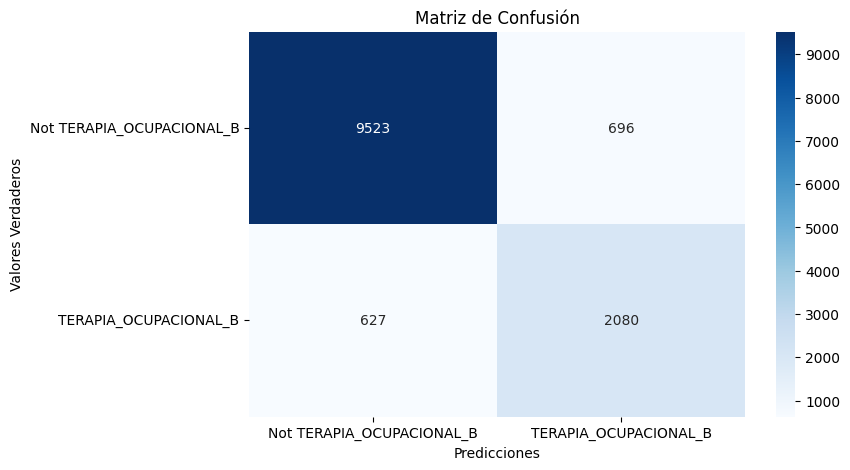

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_ter['TERAPIA_OCUPACIONAL_B'], y_pred_ter_knn.round())

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'], yticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 2 Random Forest - Terapia Ocupacional

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Cambiando el modelo a clasificador
classifier = RandomForestClassifier()

def report(results, n_top=3):  # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Parameters: {0}".format(results['params'][candidate]))
            # Agregando la impresión del F1 score
            print("Mean F1 score: {0:.5f}".format(results['mean_test_score'][candidate]))
            print("")

# Hiperparametrización
param_dist = {
    "n_estimators": [32, 64, 128],  # Number of trees in random forest
    "max_features": ['log2', 'sqrt'],  # Number of features to consider at every split
    "max_depth": [24, 16, 8],  # Maximum number of levels in tree
    "min_samples_split": [2, 4, 6],  # Minimum number of samples required to split a node
    "min_samples_leaf": [8, 12, 16],  # Minimum number of samples required at each leaf node
    "bootstrap": [True, False]  # Method of selecting samples for training each tree
}

# Configurar GridSearchCV para usar el F1 score como métrica
f1_scorer = make_scorer(f1_score, pos_label=0)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_dist, cv=5, scoring=f1_scorer, n_jobs=-1)

grid_search.fit(X=train_set_ter.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), y=train_set_ter['TERAPIA_OCUPACIONAL_B'])

# Mostrar mejores resultados
report(grid_search.cv_results_)

Model with rank: 1
Parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 32}
Mean F1 score: 0.93741

Model with rank: 2
Parameters: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 64}
Mean F1 score: 0.93738

Model with rank: 3
Parameters: {'bootstrap': False, 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 128}
Mean F1 score: 0.93733



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

# Hiperparámetros elegidos
classifier = RandomForestClassifier(n_estimators=32, max_depth=8, max_features='log2', min_samples_leaf=8, min_samples_split=6)

# Entrenamiento
classifier.fit(X=train_set_ter.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), y=train_set_ter['TERAPIA_OCUPACIONAL_B'])

# Predicción
y_pred_ter_rf = classifier.predict(X=test_set_ter.drop(['TERAPIA_OCUPACIONAL_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(test_set_ter['TERAPIA_OCUPACIONAL_B'], y_pred_ter_rf, pos_label=0)

print("F1 Score:", f1)

F1 Score: 0.9372895417500365


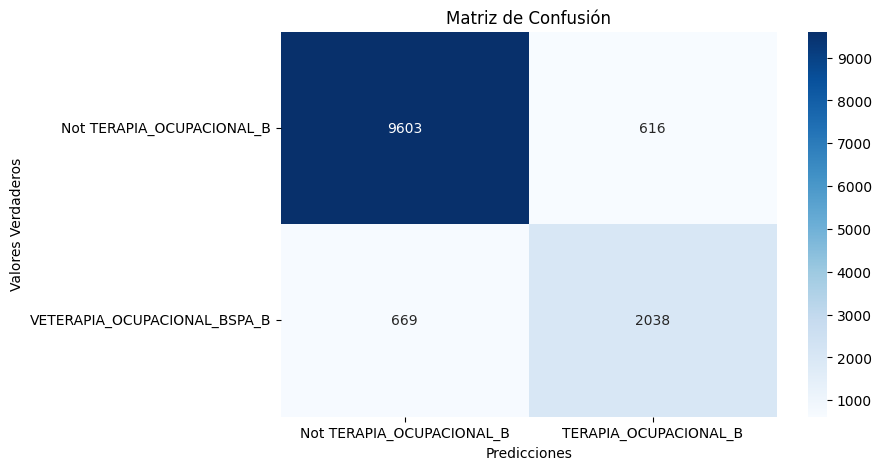

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_ter_rf = y_pred_ter_rf.round()

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_ter['TERAPIA_OCUPACIONAL_B'], y_pred_ter_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'], yticklabels=['Not TERAPIA_OCUPACIONAL_B', 'VETERAPIA_OCUPACIONAL_BSPA_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 3 AdaBoost - Terapia Ocupacional

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Definición de hiperparámetros
param_dist = {
    "n_estimators": [8, 16, 32, 64, 128],
    "learning_rate": [0.01, 0.05, 0.1],
    # 'loss' no es un parámetro en AdaBoostClassifier, por lo que se omite
}

# Creación del modelo AdaBoost con un DecisionTreeClassifier como base
grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy')),
                        param_grid=param_dist, cv=5, scoring='f1')

# Entrenamiento del modelo con el conjunto de entrenamiento
grid_ada.fit(X=train_set_ter.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), y=train_set_ter['TERAPIA_OCUPACIONAL_B'])

# Mejor modelo encontrado
best_ada = grid_ada.best_estimator_
print(best_ada)



AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=0.1, n_estimators=128)


In [ ]:
# Entrenamiento y predicción con el mejor modelo
best_ada.fit(X=train_set_ter.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), y=train_set_ter['TERAPIA_OCUPACIONAL_B'])
y_pred_ter_ada = best_ada.predict(X=test_set_ter.drop(['TERAPIA_OCUPACIONAL_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(test_set_ter['TERAPIA_OCUPACIONAL_B'], y_pred_ter_ada,pos_label=0)
print('F1 Score:', f1)


F1 Score: 0.9303729671827833


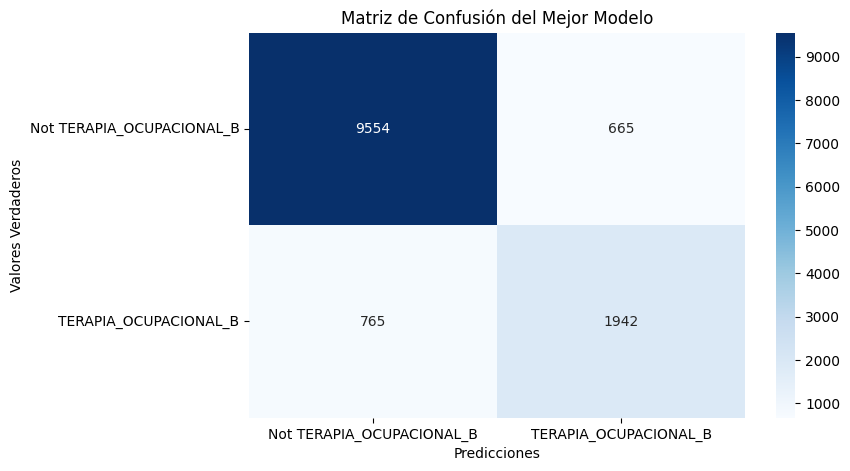

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_ter_ada = y_pred_ter_ada.round()

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_ter['TERAPIA_OCUPACIONAL_B'], y_pred_ter_ada)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'], yticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'])
plt.title('Matriz de Confusión del Mejor Modelo')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 4 Regresion Logistica - Terapia Ocupacional

In [ ]:
  # Conjunto de datos de entrenamiento
  X_train_ter = train_set_ter.drop("TERAPIA_OCUPACIONAL_B", axis=1)
  y_train_ter = train_set_ter["TERAPIA_OCUPACIONAL_B"].copy()

  # Conjunto de datos de pruebas
  X_test_ter = test_set_ter.drop("TERAPIA_OCUPACIONAL_B", axis=1)
  y_test_ter = test_set_ter["TERAPIA_OCUPACIONAL_B"].copy()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenamos un algoritmo basado en regresión logística
clf = LogisticRegression(solver="newton-cg", max_iter=1000)
clf.fit(X_train_ter, y_train_ter)

# Realizamos predicciones con el conjunto de prueba
y_pred_ter_rl = clf.predict(X_test_ter)

In [ ]:
from sklearn.metrics import f1_score
print("F1 score:", f1_score(y_test_ter, y_pred_ter_rl, pos_label=0))

F1 score: 0.9319551266349875


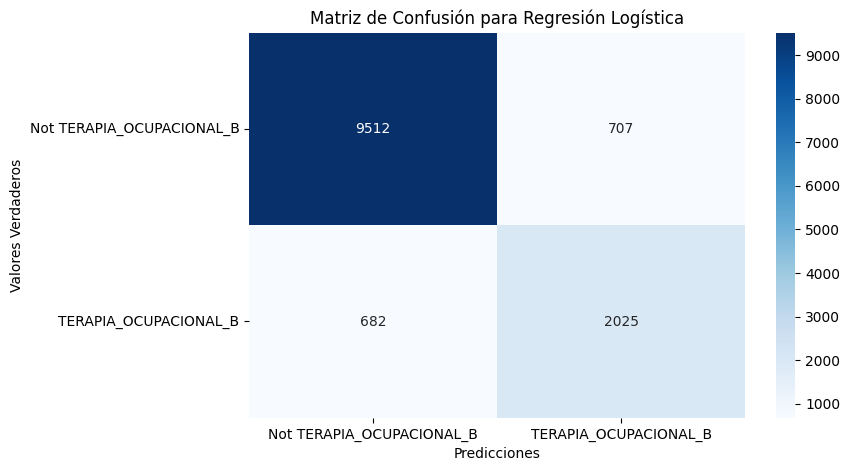

In [ ]:
# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_ter, y_pred_ter_rl)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'], yticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'])
plt.title('Matriz de Confusión para Regresión Logística')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

Curvas ROC Y PR

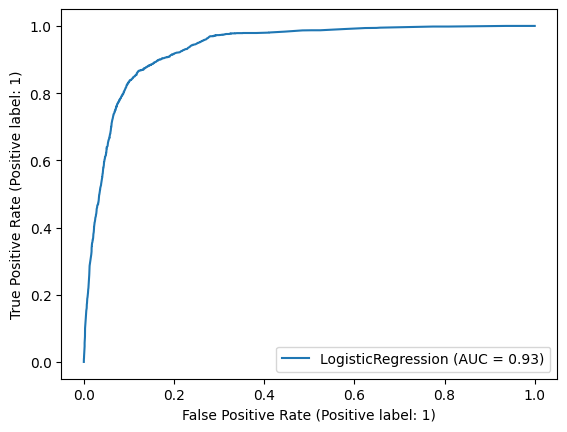

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test_ter, y_test_ter)

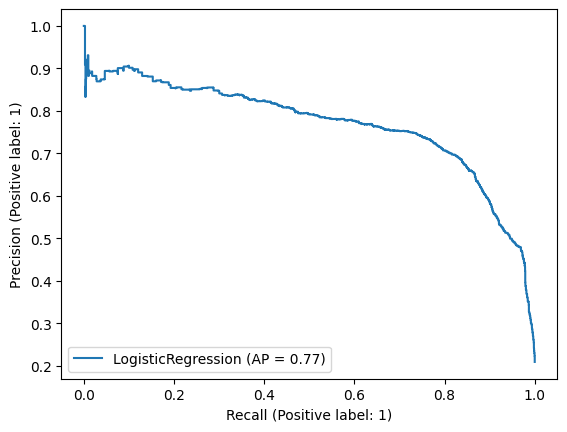

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf, X_test_ter, y_test_ter)

###Modelo 5 Arbol de decisión - Terapia Ocupacional





In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Configuración de los hiperparámetros a probar
param_grid = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Inicialización del clasificador de árbol de decisión
clf_tree = DecisionTreeClassifier(random_state=42)

# Creación del objeto GridSearchCV
grid_search = GridSearchCV(estimator=clf_tree, param_grid=param_grid, scoring=make_scorer(f1_score, average='weighted'), cv=5)

# Ajuste de GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train_ter, y_train_ter)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Mejor modelo encontrado por GridSearchCV
best_tree = grid_search.best_estimator_

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [ ]:
# Predicción con el conjunto de entrenamiento usando el mejor modelo
y_pred_ter_dt = best_tree.predict(X_test_ter)

# Cálculo del F1 Score para el conjunto de entrenamiento
print("F1 Score Test Set:", f1_score(y_test_ter, y_pred_ter_dt, pos_label=0))

F1 Score Test Set: 0.9342162925451624


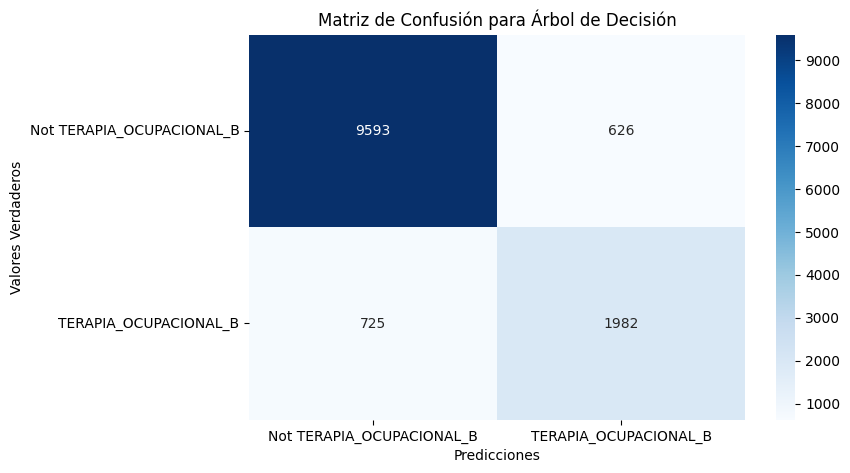

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicción con el conjunto de prueba
y_pred_ter_rf = best_tree.predict(X_test_ter)

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_ter, y_pred_ter_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'], yticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'])
plt.title('Matriz de Confusión para Árbol de Decisión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


###Resultados de los modelos - Servicio Terapia Ocupacional





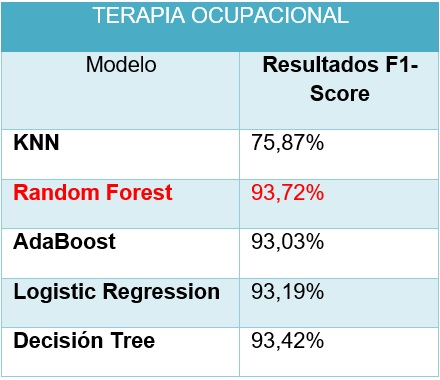

### SERVICIO ATENCIÓN MEDICA

### Preparación del modelo

In [ ]:
## Escoger base de entrenamiento y validacion
columnas_selecmed = ['EDAD_ACTUAL', 'ATENCION_ENFERMERIA_B', 'INTERVENCIONES_B', 'ODONTOLOGIA_B', 'VESPA_B', 'NUTRICION_B', 'DOCUMENTACION_B', 'ESTRATO', 'VALORACIONES_B', 'PLAN_DE_INTERVENCION_B', 'ATENCION_MEDICA_B']
idipron_med = idipron_final[columnas_selecmed]


In [ ]:
train_set_med, test_set_med = train_test_split(idipron_med, test_size=0.3, random_state=42, stratify=idipron_med["ATENCION_MEDICA_B"])
train_set_med.reset_index(drop=True, inplace=True)
test_set_med.reset_index(drop=True, inplace=True)
train_set_med.head(5)

,EDAD_ACTUAL,ATENCION_ENFERMERIA_B,INTERVENCIONES_B,ODONTOLOGIA_B,VESPA_B,NUTRICION_B,DOCUMENTACION_B,ESTRATO,VALORACIONES_B,PLAN_DE_INTERVENCION_B,ATENCION_MEDICA_B
0,19.0,1,0,0,1,0,0,2,0,0,0
1,21.0,1,1,1,1,0,0,3,1,1,1
2,23.0,0,0,0,1,0,0,1,0,0,0
3,10.0,0,0,0,0,0,0,2,0,0,0
4,29.0,1,1,0,1,0,0,1,0,0,0


### Modelo 1 KNN - Servicio Medico

Max Value uniform : 0.6603424286155115 (59)
Max Value distance : 0.6383090840876325 (55)


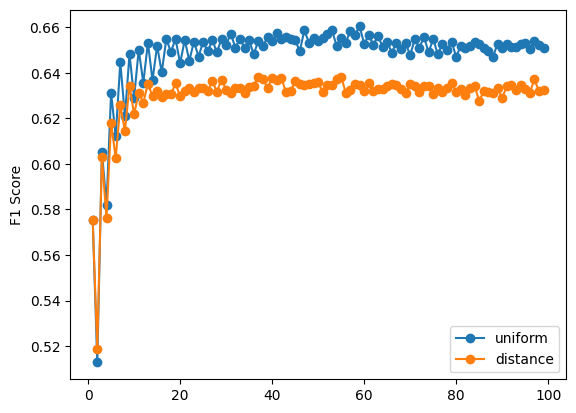

In [ ]:
cv = KFold(n_splits = 10, shuffle = True)

for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []
    for n_neighbors in range(1, 100):
        fold_f1_scores = []  # Changed variable name to reflect F1 scores
        knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        # Iterate through cross-validation splits
        for train_fold, test_fold in cv.split(train_set_med):
            # Split data
            f_train = train_set_med.loc[train_fold]
            f_test = train_set_med.loc[test_fold]
            # Train and predict
            knn.fit(X=f_train.drop(['ATENCION_MEDICA_B'], axis=1), y=f_train['ATENCION_MEDICA_B'])
            y_pred = knn.predict(X=f_test.drop(['ATENCION_MEDICA_B'], axis=1))
            # Evaluate using F1 score
            f1 = f1_score(f_test['ATENCION_MEDICA_B'], y_pred.round())
            fold_f1_scores.append(f1)
        total_scores.append(sum(fold_f1_scores) / len(fold_f1_scores))

    plt.plot(range(1, len(total_scores) + 1), total_scores, marker='o', label=weights)
    print('Max Value ' + weights + " : " + str(max(total_scores)) + " (" + str(np.argmax(total_scores) + 1) + ")")
    plt.ylabel('F1 Score')


plt.legend()
plt.show()

In [ ]:
# Resultado de la parametrización y elección de K's y peso
n_neighbors = 59
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights)
# fit, estimación y resultado

knn.fit( X = train_set_med.drop(['ATENCION_MEDICA_B'], axis=1), y = train_set_med['ATENCION_MEDICA_B'])
y_pred_med_knn = knn.predict(X = test_set_med.drop(['ATENCION_MEDICA_B'], axis = 1))
f1 = f1_score(test_set_med['ATENCION_MEDICA_B'], y_pred_med_knn.round())
print ('F1', f1)

F1 0.6693840579710144


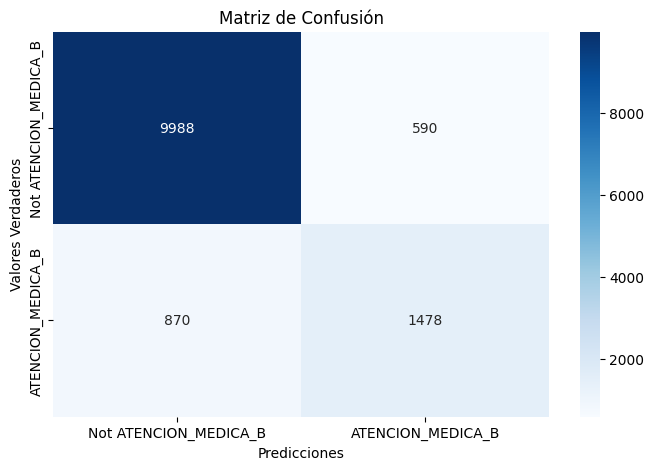

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_med['ATENCION_MEDICA_B'], y_pred_med_knn.round())

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ATENCION_MEDICA_B', 'ATENCION_MEDICA_B'], yticklabels=['Not ATENCION_MEDICA_B', 'ATENCION_MEDICA_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 2 Random Forest - Servicio Medico

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Cambiando el modelo a clasificador
classifier = RandomForestClassifier()

def report(results, n_top=3):  # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Parameters: {0}".format(results['params'][candidate]))
            # Agregando la impresión del F1 score
            print("Mean F1 score: {0:.5f}".format(results['mean_test_score'][candidate]))
            print("")

# Hiperparametrización
param_dist = {
    "n_estimators": [32, 64, 128],  # Number of trees in random forest
    "max_features": ['log2', 'sqrt'],  # Number of features to consider at every split
    "max_depth": [24, 16, 8],  # Maximum number of levels in tree
    "min_samples_split": [2, 4, 6],  # Minimum number of samples required to split a node
    "min_samples_leaf": [8, 12, 16],  # Minimum number of samples required at each leaf node
    "bootstrap": [True, False]  # Method of selecting samples for training each tree
}

# Configurar GridSearchCV para usar el F1 score como métrica
f1_scorer = make_scorer(f1_score, pos_label=0)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_dist, cv=5, scoring=f1_scorer, n_jobs=-1)

grid_search.fit(X=train_set_med.drop(['ATENCION_MEDICA_B'], axis=1), y=train_set_med['ATENCION_MEDICA_B'])

# Mostrar mejores resultados
report(grid_search.cv_results_)

Model with rank: 1
Parameters: {'bootstrap': True, 'max_depth': 24, 'max_features': 'log2', 'min_samples_leaf': 16, 'min_samples_split': 2, 'n_estimators': 32}
Mean F1 score: 0.93154

Model with rank: 2
Parameters: {'bootstrap': True, 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 64}
Mean F1 score: 0.93139

Model with rank: 3
Parameters: {'bootstrap': True, 'max_depth': 24, 'max_features': 'log2', 'min_samples_leaf': 16, 'min_samples_split': 6, 'n_estimators': 128}
Mean F1 score: 0.93138



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

# Hiperparámetros elegidos
classifier = RandomForestClassifier(n_estimators=32, max_depth=24, max_features='log2', min_samples_leaf=16, min_samples_split=2)

# Entrenamiento
classifier.fit(X=train_set_med.drop(['ATENCION_MEDICA_B'], axis=1), y=train_set_med['ATENCION_MEDICA_B'])

# Predicción
y_pred_med_rf = classifier.predict(X=test_set_med.drop(['ATENCION_MEDICA_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(test_set_med['ATENCION_MEDICA_B'], y_pred_med_rf, pos_label=0)

print("F1 Score:", f1)


F1 Score: 0.9335886418830563


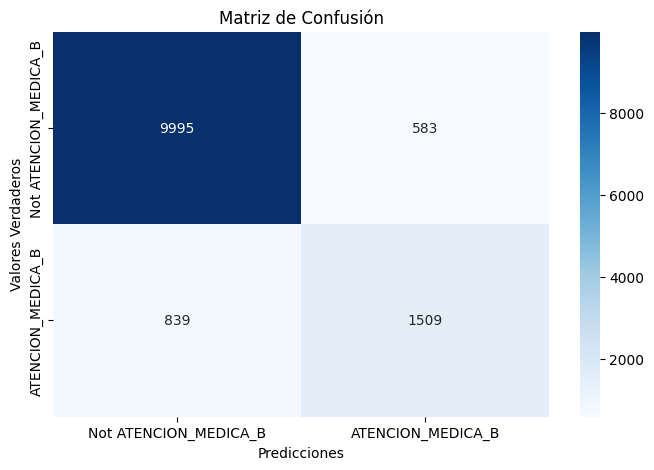

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_med_rf = y_pred_med_rf.round()

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_med['ATENCION_MEDICA_B'], y_pred_med_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ATENCION_MEDICA_B', 'ATENCION_MEDICA_B'], yticklabels=['Not ATENCION_MEDICA_B', 'ATENCION_MEDICA_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


###Modelo 3 AdaBoost - Servicio Medico

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Definición de hiperparámetros
param_dist = {
    "n_estimators": [8, 16, 32, 64, 128],
    "learning_rate": [0.01, 0.05, 0.1],
    # 'loss' no es un parámetro en AdaBoostClassifier, por lo que se omite
}

# Creación del modelo AdaBoost con un DecisionTreeClassifier como base
grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy')),
                        param_grid=param_dist, cv=5, scoring='f1')

# Entrenamiento del modelo con el conjunto de entrenamiento
grid_ada.fit(X=train_set_med.drop(['ATENCION_MEDICA_B'], axis=1), y=train_set_med['ATENCION_MEDICA_B'])

# Mejor modelo encontrado
best_ada = grid_ada.best_estimator_
print(best_ada)



AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=0.05, n_estimators=64)


In [ ]:
# Entrenamiento y predicción con el mejor modelo
best_ada.fit(X=train_set_med.drop(['ATENCION_MEDICA_B'], axis=1), y=train_set_med['ATENCION_MEDICA_B'])
y_pred_med_ada = best_ada.predict(X=test_set_med.drop(['ATENCION_MEDICA_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(test_set_med['ATENCION_MEDICA_B'], y_pred_med_ada, average='weighted')
print('F1 Score:', f1)


F1 Score: 0.8774719536341313


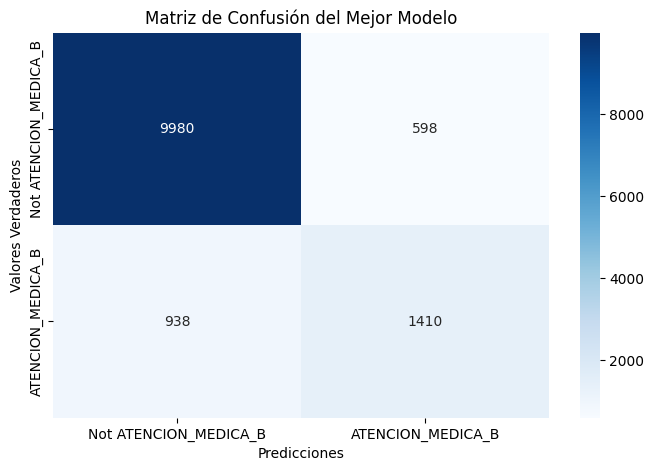

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_med_ada = y_pred_med_ada.round()

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(test_set_med['ATENCION_MEDICA_B'], y_pred_med_ada)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ATENCION_MEDICA_B', 'ATENCION_MEDICA_B'], yticklabels=['Not ATENCION_MEDICA_B', 'ATENCION_MEDICA_B'])
plt.title('Matriz de Confusión del Mejor Modelo')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 4 Regresion Logistica - Servicio Medico


In [ ]:
  # Conjunto de datos de entrenamiento
  X_train_med = train_set_med.drop("ATENCION_MEDICA_B", axis=1)
  y_train_med = train_set_med["ATENCION_MEDICA_B"].copy()

  # Conjunto de datos de pruebas
  X_test_med = test_set_med.drop("ATENCION_MEDICA_B", axis=1)
  y_test_med = test_set_med["ATENCION_MEDICA_B"].copy()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenamos un algoritmo basado en regresión logística
clf = LogisticRegression(solver="newton-cg", max_iter=1000)
clf.fit(X_train_med, y_train_med)

# Realizamos predicciones con el conjunto de prueba
y_pred_med_rl = clf.predict(X_test_med)

In [ ]:
from sklearn.metrics import f1_score
print("F1 score:", f1_score(y_test_med, y_pred_med_rl, pos_label=0))

F1 score: 0.9333458153903764


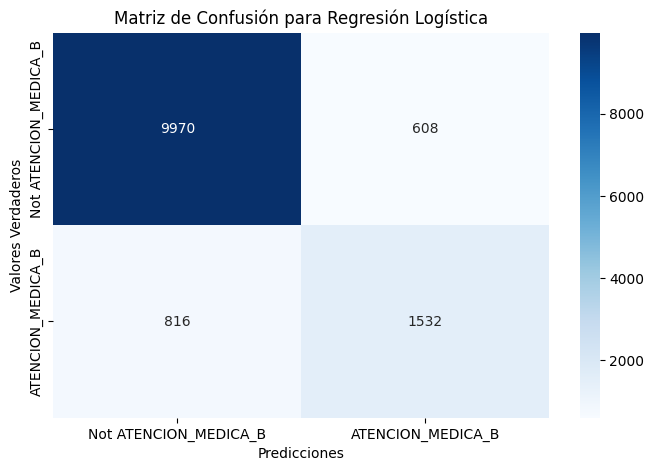

In [ ]:
# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_med, y_pred_med_rl)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ATENCION_MEDICA_B', 'ATENCION_MEDICA_B'], yticklabels=['Not ATENCION_MEDICA_B', 'ATENCION_MEDICA_B'])
plt.title('Matriz de Confusión para Regresión Logística')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

Curvas ROC Y PR

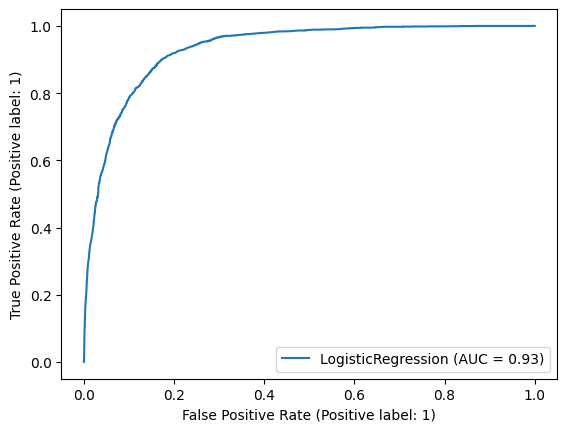

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test_med, y_test_med)

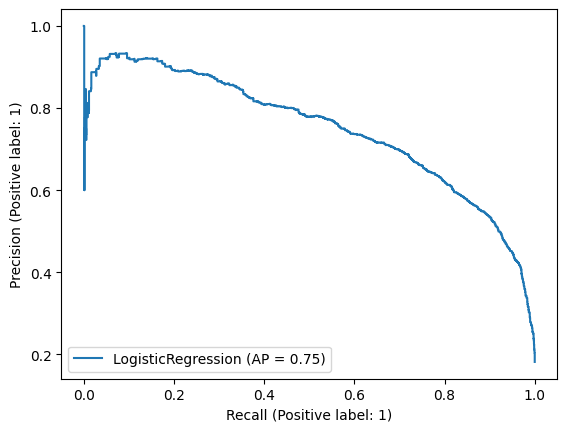

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf, X_test_med, y_test_med)

###Modelo 5 Arbol de decisión - Servicio Medico

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Configuración de los hiperparámetros a probar
param_grid = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Inicialización del clasificador de árbol de decisión
clf_tree = DecisionTreeClassifier(random_state=42)

# Creación del objeto GridSearchCV
grid_search = GridSearchCV(estimator=clf_tree, param_grid=param_grid, scoring=make_scorer(f1_score, average='weighted'), cv=5)

# Ajuste de GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train_med, y_train_med)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Mejor modelo encontrado por GridSearchCV
best_tree = grid_search.best_estimator_

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [ ]:
# Predicción con el conjunto de entrenamiento usando el mejor modelo
y_pred_med_dt = best_tree.predict(X_test_med)

# Cálculo del F1 Score para el conjunto de entrenamiento
print("F1 Score Test Set:", f1_score(y_test_med, y_pred_med_dt, pos_label=0))

F1 Score Test Set: 0.9322447447447447


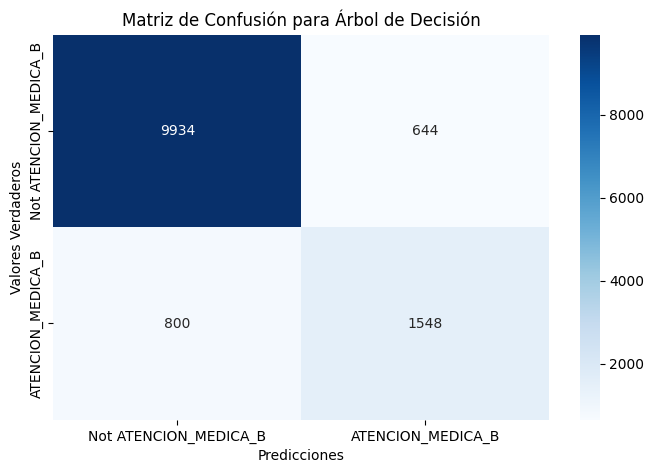

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicción con el conjunto de prueba
y_pred_med_rf = best_tree.predict(X_test_med)

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_med, y_pred_med_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ATENCION_MEDICA_B', 'ATENCION_MEDICA_B'], yticklabels=['Not ATENCION_MEDICA_B', 'ATENCION_MEDICA_B'])
plt.title('Matriz de Confusión para Árbol de Decisión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


###Resultados de los modelos - Servicio Atención Medica

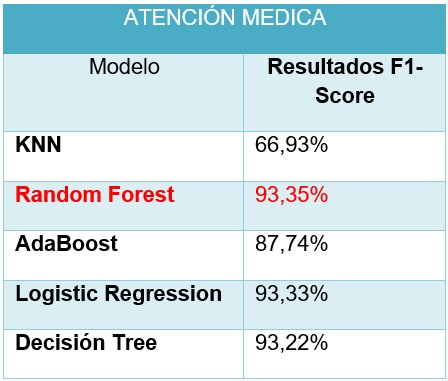